# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [6]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [7]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


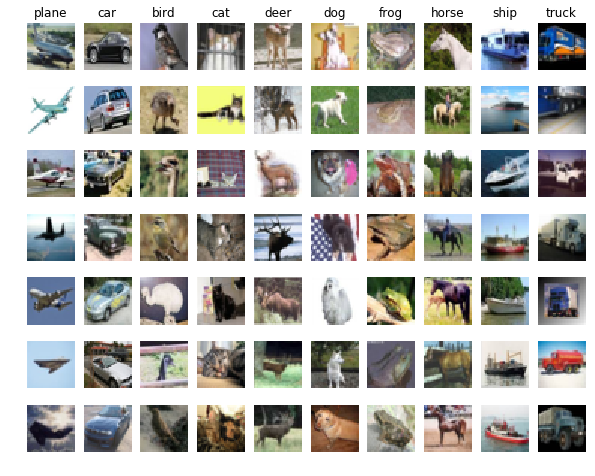

In [8]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [9]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [10]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


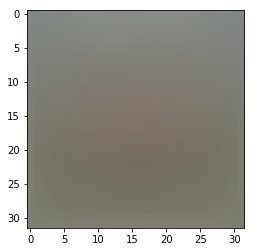

In [11]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [12]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [13]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [14]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.919160


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [15]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 6.265143 analytic: 6.162692, relative error: 8.243685e-03
numerical: 32.066734 analytic: 32.066734, relative error: 1.111070e-11
numerical: 4.423181 analytic: 4.482737, relative error: 6.687322e-03
numerical: -2.485307 analytic: -2.485307, relative error: 1.042573e-10
numerical: 2.320446 analytic: 2.276275, relative error: 9.609196e-03
numerical: -23.379658 analytic: -23.379658, relative error: 1.410750e-11
numerical: 4.565823 analytic: 4.539266, relative error: 2.916689e-03
numerical: 31.841871 analytic: 31.852065, relative error: 1.600528e-04
numerical: -8.312569 analytic: -8.312569, relative error: 5.159235e-11
numerical: 4.121599 analytic: 4.116178, relative error: 6.581061e-04
numerical: 19.744742 analytic: 19.744742, relative error: 1.720700e-11
numerical: 5.710479 analytic: 5.674048, relative error: 3.200069e-03
numerical: -9.217306 analytic: -9.217306, relative error: 4.902598e-12
numerical: -16.888848 analytic: -16.888848, relative error: 4.380096e-11
numerical: -8.

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [16]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.919160e+00 computed in 0.368550s
0.00180697441101
mask_mat[margins > 0] = 1 0.00226211547852
cube = 0.130044937134
correct_class_gradients = 0.175966024399
cube[range(0, num_train), :, y]: 0.214490890503
(500,)
(500, 3073)
dW = np.sum(cube, axis=0): 0.235384941101
0.236017942429
Vectorized loss: 8.919160e+00 computed in 0.247246s
difference: 0.000000


In [17]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.299335s
0.000837087631226
mask_mat[margins > 0] = 1 0.00130391120911
cube = 0.128890991211
correct_class_gradients = 0.174417972565
cube[range(0, num_train), :, y]: 0.207096099854
(500,)
(500, 3073)
dW = np.sum(cube, axis=0): 0.228591918945
0.229233026505
Vectorized loss and gradient: computed in 0.240619s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [ ]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
import time
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

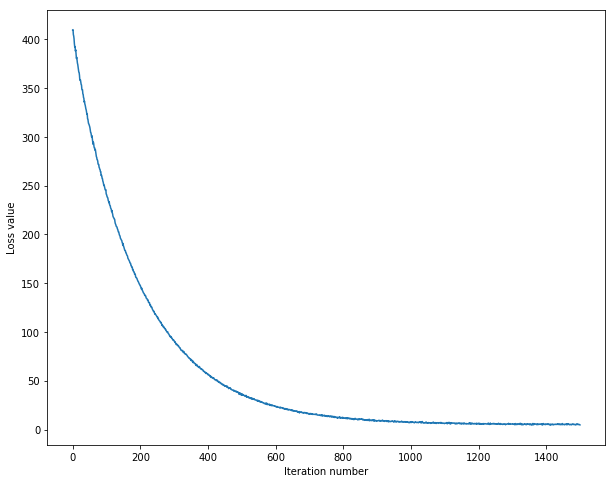

In [19]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.383510
validation accuracy: 0.390000


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
pass
from itertools import product
for lr, reg in product(learning_rates, regularization_strengths):
    svm = LinearSVM()
    tic = time.time()
    loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                          num_iters=1500, verbose=True)
    toc = time.time()
    print('That took %fs' % (toc - tic))
    # Write the LinearSVM.predict function and evaluate the performance on both the
    # training and validation set
    y_train_pred = svm.predict(X_train)
    train_accuracy = np.mean(y_train == y_train_pred)
    print('training accuracy: %f' % (train_accuracy, ))
    y_val_pred = svm.predict(X_val)
    val_accuracy = np.mean(y_val == y_val_pred)
    print('validation accuracy: %f' % (val_accuracy, ))
    results[(lr, reg)] = (train_accuracy, val_accuracy)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
 
print('best validation accuracy achieved during cross-validation: %f' % best_val)

0.000669956207275
mask_mat[margins > 0] = 1 0.00137305259705
cube = 0.0539939403534
correct_class_gradients = 0.0730290412903
cube[range(0, num_train), :, y]: 0.0868849754333
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0964658260345
0.0971128940582
iteration 0 / 1500: loss 397.223452
0.000682830810547
mask_mat[margins > 0] = 1 0.00113797187805
cube = 0.0552659034729
correct_class_gradients = 0.0743930339813
cube[range(0, num_train), :, y]: 0.0880949497223
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0991139411926
0.0997610092163
0.000659942626953
mask_mat[margins > 0] = 1 0.00110387802124
cube = 0.0544049739838
correct_class_gradients = 0.0733079910278
cube[range(0, num_train), :, y]: 0.0866279602051
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0962119102478
0.0968608856201
0.000478029251099
mask_mat[margins > 0] = 1 0.000958919525146
cube = 0.055969953537
correct_class_gradients = 0.0748779773712
cube[range(0, num_train), :, y]: 0.0900139808655
(200,)
(200, 3073)
dW = np.sum

cube = 0.0591778755188
correct_class_gradients = 0.0781948566437
cube[range(0, num_train), :, y]: 0.0920820236206
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102265834808
0.102917909622
0.00158286094666
mask_mat[margins > 0] = 1 0.00205492973328
cube = 0.0572438240051
correct_class_gradients = 0.0762078762054
cube[range(0, num_train), :, y]: 0.0897178649902
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0992319583893
0.0998828411102
0.000576019287109
mask_mat[margins > 0] = 1 0.0010678768158
cube = 0.0594010353088
correct_class_gradients = 0.0784258842468
cube[range(0, num_train), :, y]: 0.0919120311737
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102480888367
0.103124856949
0.000492095947266
mask_mat[margins > 0] = 1 0.000972032546997
cube = 0.0547490119934
correct_class_gradients = 0.073667049408
cube[range(0, num_train), :, y]: 0.0891380310059
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0990269184113
0.0996739864349
0.000508069992065
mask_mat[margins > 0] = 1 0.000987052

cube = 0.0574510097504
correct_class_gradients = 0.0777289867401
cube[range(0, num_train), :, y]: 0.0917828083038
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102213859558
0.102863788605
0.000501155853271
mask_mat[margins > 0] = 1 0.000967979431152
cube = 0.0557689666748
correct_class_gradients = 0.0758509635925
cube[range(0, num_train), :, y]: 0.0898160934448
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100188016891
0.100836038589
0.00119400024414
mask_mat[margins > 0] = 1 0.00171399116516
cube = 0.0585820674896
correct_class_gradients = 0.0785188674927
cube[range(0, num_train), :, y]: 0.0928230285645
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.103045940399
0.103770017624
0.000563144683838
mask_mat[margins > 0] = 1 0.00105714797974
cube = 0.0561940670013
correct_class_gradients = 0.0759370326996
cube[range(0, num_train), :, y]: 0.0908110141754
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100462198257
0.101323127747
0.000478982925415
mask_mat[margins > 0] = 1 0.00096511840

cube = 0.0580811500549
correct_class_gradients = 0.0780320167542
cube[range(0, num_train), :, y]: 0.092483997345
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102802038193
0.103449106216
0.000611066818237
mask_mat[margins > 0] = 1 0.00110006332397
cube = 0.0570628643036
correct_class_gradients = 0.0773589611053
cube[range(0, num_train), :, y]: 0.0915260314941
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101495027542
0.102156877518
0.000500917434692
mask_mat[margins > 0] = 1 0.00113105773926
cube = 0.0578720569611
correct_class_gradients = 0.0780539512634
cube[range(0, num_train), :, y]: 0.0922520160675
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102085113525
0.102733135223
0.000486135482788
mask_mat[margins > 0] = 1 0.000984191894531
cube = 0.0563261508942
correct_class_gradients = 0.0762331485748
cube[range(0, num_train), :, y]: 0.0901081562042
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100378990173
0.101052999496
0.000627040863037
mask_mat[margins > 0] = 1 0.00109720230

cube = 0.0578861236572
correct_class_gradients = 0.0776550769806
cube[range(0, num_train), :, y]: 0.0916121006012
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102421998978
0.103070020676
0.000828981399536
mask_mat[margins > 0] = 1 0.00129008293152
cube = 0.0572459697723
correct_class_gradients = 0.0769939422607
cube[range(0, num_train), :, y]: 0.103201150894
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.114310979843
0.114974975586
0.00130987167358
mask_mat[margins > 0] = 1 0.00178289413452
cube = 0.0583539009094
correct_class_gradients = 0.0783779621124
cube[range(0, num_train), :, y]: 0.0925769805908
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102391958237
0.103043794632
0.000515937805176
mask_mat[margins > 0] = 1 0.000988960266113
cube = 0.0572509765625
correct_class_gradients = 0.0769319534302
cube[range(0, num_train), :, y]: 0.090980052948
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101159095764
0.101834058762
0.000492811203003
mask_mat[margins > 0] = 1 0.0009689331054

cube = 0.0575819015503
correct_class_gradients = 0.0777139663696
cube[range(0, num_train), :, y]: 0.091894865036
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.10164308548
0.102288961411
0.000497102737427
mask_mat[margins > 0] = 1 0.000972032546997
cube = 0.0555689334869
correct_class_gradients = 0.0751600265503
cube[range(0, num_train), :, y]: 0.0898749828339
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0999779701233
0.10062789917
0.000488042831421
mask_mat[margins > 0] = 1 0.000952959060669
cube = 0.058226108551
correct_class_gradients = 0.0782771110535
cube[range(0, num_train), :, y]: 0.0923881530762
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102250099182
0.102931022644
0.000495910644531
mask_mat[margins > 0] = 1 0.000979900360107
cube = 0.0563650131226
correct_class_gradients = 0.0758829116821
cube[range(0, num_train), :, y]: 0.0904898643494
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100380897522
0.10103392601
0.000509977340698
mask_mat[margins > 0] = 1 0.000992059707

cube = 0.0594568252563
correct_class_gradients = 0.0794758796692
cube[range(0, num_train), :, y]: 0.0933659076691
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.10346698761
0.104120016098
0.00067400932312
mask_mat[margins > 0] = 1 0.00114607810974
cube = 0.0559689998627
correct_class_gradients = 0.0756869316101
cube[range(0, num_train), :, y]: 0.0897209644318
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.099552154541
0.100208997726
0.000488996505737
mask_mat[margins > 0] = 1 0.000956058502197
cube = 0.0590648651123
correct_class_gradients = 0.078626871109
cube[range(0, num_train), :, y]: 0.0925588607788
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102681875229
0.103525876999
0.000483989715576
mask_mat[margins > 0] = 1 0.000957012176514
cube = 0.0564260482788
correct_class_gradients = 0.075847864151
cube[range(0, num_train), :, y]: 0.0895359516144
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0993900299072
0.100035905838
0.000493049621582
mask_mat[margins > 0] = 1 0.000964164733

cube = 0.0571429729462
correct_class_gradients = 0.0766580104828
cube[range(0, num_train), :, y]: 0.0910551548004
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101398944855
0.102055072784
0.000617980957031
mask_mat[margins > 0] = 1 0.00108981132507
cube = 0.0569739341736
correct_class_gradients = 0.0767040252686
cube[range(0, num_train), :, y]: 0.0906879901886
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100519895554
0.101173877716
0.000484943389893
mask_mat[margins > 0] = 1 0.000952959060669
cube = 0.0575280189514
correct_class_gradients = 0.0792179107666
cube[range(0, num_train), :, y]: 0.0930590629578
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102870941162
0.103524923325
0.000515937805176
mask_mat[margins > 0] = 1 0.00098705291748
cube = 0.0559239387512
correct_class_gradients = 0.0758008956909
cube[range(0, num_train), :, y]: 0.0894839763641
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0993928909302
0.100038051605
0.000479936599731
mask_mat[margins > 0] = 1 0.000983953

cube = 0.0573589801788
correct_class_gradients = 0.0774450302124
cube[range(0, num_train), :, y]: 0.0916130542755
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101410865784
0.102063894272
0.000489950180054
mask_mat[margins > 0] = 1 0.000968933105469
cube = 0.0562601089478
correct_class_gradients = 0.0756869316101
cube[range(0, num_train), :, y]: 0.0899181365967
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0995910167694
0.100269079208
0.000483989715576
mask_mat[margins > 0] = 1 0.000956058502197
cube = 0.0563969612122
correct_class_gradients = 0.075581073761
cube[range(0, num_train), :, y]: 0.0898640155792
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0996849536896
0.100363969803
0.000485897064209
mask_mat[margins > 0] = 1 0.000968933105469
cube = 0.0556449890137
correct_class_gradients = 0.0750019550323
cube[range(0, num_train), :, y]: 0.0907680988312
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100790977478
0.101438999176
0.000501871109009
mask_mat[margins > 0] = 1 0.0009758

cube = 0.0572340488434
correct_class_gradients = 0.0766880512238
cube[range(0, num_train), :, y]: 0.0913400650024
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101135015488
0.101786136627
0.000490188598633
mask_mat[margins > 0] = 1 0.000967979431152
cube = 0.0551459789276
correct_class_gradients = 0.0745770931244
cube[range(0, num_train), :, y]: 0.0885891914368
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.098491191864
0.0991699695587
0.000473022460938
mask_mat[margins > 0] = 1 0.000956058502197
cube = 0.0570290088654
correct_class_gradients = 0.0769190788269
cube[range(0, num_train), :, y]: 0.0913319587708
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.1011531353
0.101866960526
0.000499963760376
mask_mat[margins > 0] = 1 0.000971078872681
cube = 0.0556230545044
correct_class_gradients = 0.0759449005127
cube[range(0, num_train), :, y]: 0.089793920517
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0996699333191
0.100322961807
0.000504016876221
mask_mat[margins > 0] = 1 0.000979900

cube = 0.0605499744415
correct_class_gradients = 0.0800039768219
cube[range(0, num_train), :, y]: 0.0941479206085
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.104233980179
0.104912042618
0.00674796104431
mask_mat[margins > 0] = 1 0.00724697113037
cube = 0.0679321289062
correct_class_gradients = 0.0877289772034
cube[range(0, num_train), :, y]: 0.101531982422
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.111415147781
0.112066984177
0.000490188598633
mask_mat[margins > 0] = 1 0.0010142326355
cube = 0.0593090057373
correct_class_gradients = 0.078871011734
cube[range(0, num_train), :, y]: 0.092865228653
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102683067322
0.103338003159
0.00049090385437
mask_mat[margins > 0] = 1 0.000962972640991
cube = 0.0558459758759
correct_class_gradients = 0.0751349925995
cube[range(0, num_train), :, y]: 0.0891098976135
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0989089012146
0.09956407547
0.000632047653198
mask_mat[margins > 0] = 1 0.00110697746277
c

cube = 0.0599160194397
correct_class_gradients = 0.0796899795532
cube[range(0, num_train), :, y]: 0.0943260192871
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.104429006577
0.105077981949
0.000494956970215
mask_mat[margins > 0] = 1 0.000983953475952
cube = 0.0557940006256
correct_class_gradients = 0.0755829811096
cube[range(0, num_train), :, y]: 0.0896589756012
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0997140407562
0.10036110878
0.000489950180054
mask_mat[margins > 0] = 1 0.000971078872681
cube = 0.0597639083862
correct_class_gradients = 0.0794129371643
cube[range(0, num_train), :, y]: 0.0933480262756
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.103579998016
0.104270935059
0.000493049621582
mask_mat[margins > 0] = 1 0.000951051712036
cube = 0.0668919086456
correct_class_gradients = 0.0866270065308
cube[range(0, num_train), :, y]: 0.100368022919
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.110060930252
0.110712051392
0.000492095947266
mask_mat[margins > 0] = 1 0.000961065

cube = 0.0725789070129
correct_class_gradients = 0.0925889015198
cube[range(0, num_train), :, y]: 0.106193065643
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.116369009018
0.11705994606
0.00353002548218
mask_mat[margins > 0] = 1 0.00400805473328
cube = 0.0597939491272
correct_class_gradients = 0.0790040493011
cube[range(0, num_train), :, y]: 0.0930960178375
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102657079697
0.103306055069
0.0028281211853
mask_mat[margins > 0] = 1 0.00331616401672
cube = 0.0600070953369
correct_class_gradients = 0.0792000293732
cube[range(0, num_train), :, y]: 0.0928320884705
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102505207062
0.103166103363
0.00353503227234
mask_mat[margins > 0] = 1 0.00401496887207
cube = 0.0582571029663
correct_class_gradients = 0.0773069858551
cube[range(0, num_train), :, y]: 0.0920240879059
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101712942123
0.102392911911
0.00176191329956
mask_mat[margins > 0] = 1 0.00223183631897
cub

cube = 0.0573899745941
correct_class_gradients = 0.076602935791
cube[range(0, num_train), :, y]: 0.0902450084686
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0998730659485
0.100523948669
0.000962018966675
mask_mat[margins > 0] = 1 0.00144410133362
cube = 0.0554840564728
correct_class_gradients = 0.0745451450348
cube[range(0, num_train), :, y]: 0.0885450839996
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0981040000916
0.0987720489502
0.000646114349365
mask_mat[margins > 0] = 1 0.00111317634583
cube = 0.057343006134
correct_class_gradients = 0.0766050815582
cube[range(0, num_train), :, y]: 0.0901482105255
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0997941493988
0.100457191467
0.000502824783325
mask_mat[margins > 0] = 1 0.000970840454102
cube = 0.0563929080963
correct_class_gradients = 0.0755980014801
cube[range(0, num_train), :, y]: 0.0892889499664
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0988938808441
0.099604845047
0.00278687477112
mask_mat[margins > 0] = 1 0.00330090

cube = 0.0558948516846
correct_class_gradients = 0.0749099254608
cube[range(0, num_train), :, y]: 0.088583946228
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0982019901276
0.0988528728485
0.000525951385498
mask_mat[margins > 0] = 1 0.00101089477539
cube = 0.0547349452972
correct_class_gradients = 0.0738689899445
cube[range(0, num_train), :, y]: 0.087641954422
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0974578857422
0.0981109142303
0.00151586532593
mask_mat[margins > 0] = 1 0.00200200080872
cube = 0.0573780536652
correct_class_gradients = 0.0765109062195
cube[range(0, num_train), :, y]: 0.0900859832764
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0997860431671
0.100436925888
0.000491142272949
mask_mat[margins > 0] = 1 0.000981092453003
cube = 0.0546200275421
correct_class_gradients = 0.0737960338593
cube[range(0, num_train), :, y]: 0.0875840187073
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.097118139267
0.0977711677551
0.00051212310791
mask_mat[margins > 0] = 1 0.00097703

cube = 0.0574169158936
correct_class_gradients = 0.0767788887024
cube[range(0, num_train), :, y]: 0.0912728309631
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100895881653
0.101542949677
0.00048303604126
mask_mat[margins > 0] = 1 0.000952959060669
cube = 0.0549941062927
correct_class_gradients = 0.0739829540253
cube[range(0, num_train), :, y]: 0.0876319408417
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0971961021423
0.0978500843048
0.000479936599731
mask_mat[margins > 0] = 1 0.000949859619141
cube = 0.0554938316345
correct_class_gradients = 0.0745348930359
cube[range(0, num_train), :, y]: 0.0882749557495
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.097886800766
0.0985329151154
0.000483989715576
mask_mat[margins > 0] = 1 0.00103402137756
cube = 0.0545990467072
correct_class_gradients = 0.0735900402069
cube[range(0, num_train), :, y]: 0.0870349407196
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0966410636902
0.097363948822
0.000483989715576
mask_mat[margins > 0] = 1 0.000959

cube = 0.0556709766388
correct_class_gradients = 0.0746459960938
cube[range(0, num_train), :, y]: 0.0881159305573
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0976550579071
0.0983090400696
0.000486135482788
mask_mat[margins > 0] = 1 0.000963926315308
cube = 0.054582118988
correct_class_gradients = 0.0735630989075
cube[range(0, num_train), :, y]: 0.0872840881348
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0969240665436
0.0975680351257
0.000488996505737
mask_mat[margins > 0] = 1 0.000960826873779
cube = 0.0553798675537
correct_class_gradients = 0.0742568969727
cube[range(0, num_train), :, y]: 0.087849855423
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0974099636078
0.0980608463287
0.000486135482788
mask_mat[margins > 0] = 1 0.000952005386353
cube = 0.0548479557037
correct_class_gradients = 0.0737619400024
cube[range(0, num_train), :, y]: 0.0872631072998
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0967531204224
0.0973999500275
0.000481843948364
mask_mat[margins > 0] = 1 0.00

cube = 0.0557868480682
correct_class_gradients = 0.0748209953308
cube[range(0, num_train), :, y]: 0.08837890625
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0979678630829
0.0986368656158
0.00048303604126
mask_mat[margins > 0] = 1 0.000940084457397
cube = 0.0542240142822
correct_class_gradients = 0.0732891559601
cube[range(0, num_train), :, y]: 0.0879261493683
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0977070331573
0.0983531475067
0.000483989715576
mask_mat[margins > 0] = 1 0.000957012176514
cube = 0.0553030967712
correct_class_gradients = 0.0742871761322
cube[range(0, num_train), :, y]: 0.0877912044525
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0972862243652
0.097941160202
0.00067400932312
mask_mat[margins > 0] = 1 0.00115609169006
cube = 0.0548250675201
correct_class_gradients = 0.0737519264221
cube[range(0, num_train), :, y]: 0.0871798992157
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0966789722443
0.0973238945007
0.000473022460938
mask_mat[margins > 0] = 1 0.000940

cube = 0.05703997612
correct_class_gradients = 0.0778021812439
cube[range(0, num_train), :, y]: 0.0912730693817
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.10168504715
0.102343082428
0.000510931015015
mask_mat[margins > 0] = 1 0.000981092453003
cube = 0.0569159984589
correct_class_gradients = 0.0758340358734
cube[range(0, num_train), :, y]: 0.0893459320068
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0996050834656
0.100251913071
0.000478029251099
mask_mat[margins > 0] = 1 0.000951051712036
cube = 0.0573129653931
correct_class_gradients = 0.0762810707092
cube[range(0, num_train), :, y]: 0.0899610519409
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0995719432831
0.100227117538
0.00146698951721
mask_mat[margins > 0] = 1 0.00196194648743
cube = 0.0565559864044
correct_class_gradients = 0.075464963913
cube[range(0, num_train), :, y]: 0.0891308784485
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100064992905
0.100719928741
0.000477075576782
mask_mat[margins > 0] = 1 0.000946044921

cube = 0.0557160377502
correct_class_gradients = 0.0747029781342
cube[range(0, num_train), :, y]: 0.0881440639496
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0976669788361
0.0983150005341
0.000904083251953
mask_mat[margins > 0] = 1 0.00137710571289
cube = 0.054790019989
correct_class_gradients = 0.0737860202789
cube[range(0, num_train), :, y]: 0.0874772071838
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0969271659851
0.0975790023804
0.000485181808472
mask_mat[margins > 0] = 1 0.000960111618042
cube = 0.0555200576782
correct_class_gradients = 0.074501991272
cube[range(0, num_train), :, y]: 0.0879299640656
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0976741313934
0.0983300209045
0.000500202178955
mask_mat[margins > 0] = 1 0.000962018966675
cube = 0.0543971061707
correct_class_gradients = 0.0732901096344
cube[range(0, num_train), :, y]: 0.0868601799011
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.112047195435
0.112721204758
0.000516891479492
mask_mat[margins > 0] = 1 0.00101

cube = 0.0555830001831
correct_class_gradients = 0.0745038986206
cube[range(0, num_train), :, y]: 0.0884890556335
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.098032951355
0.0986919403076
0.000492095947266
mask_mat[margins > 0] = 1 0.000961065292358
cube = 0.0543301105499
correct_class_gradients = 0.0733971595764
cube[range(0, num_train), :, y]: 0.0872030258179
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0967910289764
0.097442150116
0.000498056411743
mask_mat[margins > 0] = 1 0.000967025756836
cube = 0.0558049678802
correct_class_gradients = 0.0748538970947
cube[range(0, num_train), :, y]: 0.0887229442596
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0983898639679
0.0990350246429
0.000478982925415
mask_mat[margins > 0] = 1 0.000961065292358
cube = 0.0543041229248
correct_class_gradients = 0.0733451843262
cube[range(0, num_train), :, y]: 0.0878241062164
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0973510742188
0.0980041027069
0.000488996505737
mask_mat[margins > 0] = 1 0.00

cube = 0.0565650463104
correct_class_gradients = 0.0755069255829
cube[range(0, num_train), :, y]: 0.0892989635468
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0989170074463
0.0995719432831
0.000577211380005
mask_mat[margins > 0] = 1 0.00106310844421
cube = 0.0543341636658
correct_class_gradients = 0.0732932090759
cube[range(0, num_train), :, y]: 0.0868191719055
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0968101024628
0.0974600315094
0.000710010528564
mask_mat[margins > 0] = 1 0.00119709968567
cube = 0.0565311908722
correct_class_gradients = 0.0756070613861
cube[range(0, num_train), :, y]: 0.0896821022034
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0993640422821
0.10001206398
0.000499963760376
mask_mat[margins > 0] = 1 0.000988960266113
cube = 0.0543029308319
correct_class_gradients = 0.0733277797699
cube[range(0, num_train), :, y]: 0.0867989063263
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0963668823242
0.0970149040222
0.000488996505737
mask_mat[margins > 0] = 1 0.0009

cube = 0.055202960968
correct_class_gradients = 0.074156999588
cube[range(0, num_train), :, y]: 0.0879759788513
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0976569652557
0.0983078479767
0.000502109527588
mask_mat[margins > 0] = 1 0.000969171524048
cube = 0.0542380809784
correct_class_gradients = 0.073292016983
cube[range(0, num_train), :, y]: 0.0867190361023
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.096333026886
0.0969879627228
0.000908851623535
mask_mat[margins > 0] = 1 0.00137495994568
cube = 0.0559618473053
correct_class_gradients = 0.0749688148499
cube[range(0, num_train), :, y]: 0.0885198116302
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0981628894806
0.0988178253174
0.000506162643433
mask_mat[margins > 0] = 1 0.000981092453003
cube = 0.0543310642242
correct_class_gradients = 0.0733151435852
cube[range(0, num_train), :, y]: 0.0868260860443
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0963189601898
0.0969669818878
0.000478982925415
mask_mat[margins > 0] = 1 0.00096

cube = 0.0560519695282
correct_class_gradients = 0.0753347873688
cube[range(0, num_train), :, y]: 0.088898897171
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0984139442444
0.0990619659424
0.000625848770142
mask_mat[margins > 0] = 1 0.0010998249054
cube = 0.0544970035553
correct_class_gradients = 0.0734930038452
cube[range(0, num_train), :, y]: 0.0869238376617
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0964879989624
0.0971388816833
0.000478982925415
mask_mat[margins > 0] = 1 0.000961065292358
cube = 0.0553939342499
correct_class_gradients = 0.0743310451508
cube[range(0, num_train), :, y]: 0.0878798961639
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0974850654602
0.0981330871582
0.000478982925415
mask_mat[margins > 0] = 1 0.000942945480347
cube = 0.0544998645782
correct_class_gradients = 0.0736110210419
cube[range(0, num_train), :, y]: 0.0870220661163
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0964879989624
0.0971400737762
0.000493049621582
mask_mat[margins > 0] = 1 0.000

cube = 0.0555379390717
correct_class_gradients = 0.0745298862457
cube[range(0, num_train), :, y]: 0.088063955307
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.097571849823
0.0982258319855
0.000483989715576
mask_mat[margins > 0] = 1 0.000968933105469
cube = 0.0544068813324
correct_class_gradients = 0.0733768939972
cube[range(0, num_train), :, y]: 0.086847782135
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0963559150696
0.0970089435577
0.000490188598633
mask_mat[margins > 0] = 1 0.000962018966675
cube = 0.0555641651154
correct_class_gradients = 0.0745391845703
cube[range(0, num_train), :, y]: 0.087895154953
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0974249839783
0.0980751514435
0.000482082366943
mask_mat[margins > 0] = 1 0.000977039337158
cube = 0.0548231601715
correct_class_gradients = 0.0740051269531
cube[range(0, num_train), :, y]: 0.0885860919952
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0980761051178
0.098836183548
0.000543117523193
mask_mat[margins > 0] = 1 0.00100

cube = 0.0552608966827
correct_class_gradients = 0.0743789672852
cube[range(0, num_train), :, y]: 0.0878369808197
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0973880290985
0.098042011261
0.000480175018311
mask_mat[margins > 0] = 1 0.000938177108765
cube = 0.0544261932373
correct_class_gradients = 0.0734031200409
cube[range(0, num_train), :, y]: 0.0869801044464
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0964829921722
0.0971281528473
0.000478029251099
mask_mat[margins > 0] = 1 0.000979900360107
cube = 0.0555980205536
correct_class_gradients = 0.0744500160217
cube[range(0, num_train), :, y]: 0.0878438949585
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0974509716034
0.0981049537659
0.000487089157104
mask_mat[margins > 0] = 1 0.000960111618042
cube = 0.0544340610504
correct_class_gradients = 0.0733499526978
cube[range(0, num_train), :, y]: 0.0868000984192
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0963001251221
0.0969440937042
0.00102996826172
mask_mat[margins > 0] = 1 0.00

cube = 0.0564720630646
correct_class_gradients = 0.0766849517822
cube[range(0, num_train), :, y]: 0.0901861190796
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101001024246
0.101651906967
0.000495910644531
mask_mat[margins > 0] = 1 0.000969886779785
cube = 0.0557889938354
correct_class_gradients = 0.0757119655609
cube[range(0, num_train), :, y]: 0.0891199111938
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0986199378967
0.0992748737335
0.000509023666382
mask_mat[margins > 0] = 1 0.00101089477539
cube = 0.0563268661499
correct_class_gradients = 0.0752549171448
cube[range(0, num_train), :, y]: 0.0887730121613
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0984439849854
0.0990958213806
0.000493764877319
mask_mat[margins > 0] = 1 0.000954866409302
cube = 0.0543868541718
correct_class_gradients = 0.074590921402
cube[range(0, num_train), :, y]: 0.088164806366
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.097836971283
0.0984899997711
0.000511884689331
mask_mat[margins > 0] = 1 0.000982

cube = 0.0552399158478
correct_class_gradients = 0.0741040706635
cube[range(0, num_train), :, y]: 0.0879180431366
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0975849628448
0.098237991333
0.000483989715576
mask_mat[margins > 0] = 1 0.000949144363403
cube = 0.0543451309204
correct_class_gradients = 0.0732231140137
cube[range(0, num_train), :, y]: 0.0867409706116
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0964410305023
0.0970840454102
0.0014820098877
mask_mat[margins > 0] = 1 0.00195503234863
cube = 0.0561370849609
correct_class_gradients = 0.0751180648804
cube[range(0, num_train), :, y]: 0.0884790420532
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0982179641724
0.0988709926605
0.00048303604126
mask_mat[margins > 0] = 1 0.000957012176514
cube = 0.0541989803314
correct_class_gradients = 0.0731890201569
cube[range(0, num_train), :, y]: 0.0871460437775
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.096608877182
0.0972640514374
0.000492095947266
mask_mat[margins > 0] = 1 0.000961

cube = 0.0552680492401
correct_class_gradients = 0.0743811130524
cube[range(0, num_train), :, y]: 0.0877819061279
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.097354888916
0.0980079174042
0.000622987747192
mask_mat[margins > 0] = 1 0.00108003616333
cube = 0.0541830062866
correct_class_gradients = 0.0732700824738
cube[range(0, num_train), :, y]: 0.0871150493622
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0980231761932
0.0986831188202
0.000652074813843
mask_mat[margins > 0] = 1 0.00113701820374
cube = 0.0557332038879
correct_class_gradients = 0.074728012085
cube[range(0, num_train), :, y]: 0.0883641242981
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0979599952698
0.0986120700836
0.000643014907837
mask_mat[margins > 0] = 1 0.00110483169556
cube = 0.0544219017029
correct_class_gradients = 0.0733439922333
cube[range(0, num_train), :, y]: 0.0869369506836
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.096489906311
0.0971329212189
0.00062894821167
mask_mat[margins > 0] = 1 0.0011050

cube = 0.0582981109619
correct_class_gradients = 0.0781080722809
cube[range(0, num_train), :, y]: 0.0932009220123
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.103582143784
0.104233026505
0.000661849975586
mask_mat[margins > 0] = 1 0.00112891197205
cube = 0.0565378665924
correct_class_gradients = 0.0760118961334
cube[range(0, num_train), :, y]: 0.090393781662
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.10143995285
0.102096796036
0.0012800693512
mask_mat[margins > 0] = 1 0.00177121162415
cube = 0.0593481063843
correct_class_gradients = 0.0798180103302
cube[range(0, num_train), :, y]: 0.0931661128998
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102955102921
0.103610992432
0.00153398513794
mask_mat[margins > 0] = 1 0.00200390815735
cube = 0.0568358898163
correct_class_gradients = 0.0758628845215
cube[range(0, num_train), :, y]: 0.0905678272247
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100624799728
0.101271867752
0.000488996505737
mask_mat[margins > 0] = 1 0.000969886779785


cube = 0.0558741092682
correct_class_gradients = 0.0751931667328
cube[range(0, num_train), :, y]: 0.0887501239777
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0984950065613
0.0991489887238
0.00145697593689
mask_mat[margins > 0] = 1 0.00199103355408
cube = 0.0557398796082
correct_class_gradients = 0.0749139785767
cube[range(0, num_train), :, y]: 0.0886850357056
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0981619358063
0.0988869667053
0.00134897232056
mask_mat[margins > 0] = 1 0.00181913375854
cube = 0.0568430423737
correct_class_gradients = 0.0760071277618
cube[range(0, num_train), :, y]: 0.0896589756012
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0992980003357
0.0999460220337
0.000523090362549
mask_mat[margins > 0] = 1 0.000983953475952
cube = 0.0549499988556
correct_class_gradients = 0.0740950107574
cube[range(0, num_train), :, y]: 0.0876998901367
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0973498821259
0.0980019569397
0.000494956970215
mask_mat[margins > 0] = 1 0.0010

cube = 0.0563848018646
correct_class_gradients = 0.0753698348999
cube[range(0, num_train), :, y]: 0.0893239974976
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0989809036255
0.0996279716492
0.000497102737427
mask_mat[margins > 0] = 1 0.000977039337158
cube = 0.054573059082
correct_class_gradients = 0.0740611553192
cube[range(0, num_train), :, y]: 0.0875470638275
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0971040725708
0.0977549552917
0.00047492980957
mask_mat[margins > 0] = 1 0.000946998596191
cube = 0.0555050373077
correct_class_gradients = 0.0744969844818
cube[range(0, num_train), :, y]: 0.0881600379944
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0979368686676
0.098592042923
0.00116109848022
mask_mat[margins > 0] = 1 0.00164318084717
cube = 0.0552911758423
correct_class_gradients = 0.0743451118469
cube[range(0, num_train), :, y]: 0.0878920555115
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0974640846252
0.0981152057648
0.000476837158203
mask_mat[margins > 0] = 1 0.00094

cube = 0.0577249526978
correct_class_gradients = 0.0778119564056
cube[range(0, num_train), :, y]: 0.0920209884644
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101745843887
0.10239481926
0.000846862792969
mask_mat[margins > 0] = 1 0.00131988525391
cube = 0.0558838844299
correct_class_gradients = 0.0760140419006
cube[range(0, num_train), :, y]: 0.0898869037628
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0995860099792
0.100239038467
0.00048303604126
mask_mat[margins > 0] = 1 0.000946044921875
cube = 0.0592310428619
correct_class_gradients = 0.078950881958
cube[range(0, num_train), :, y]: 0.092796087265
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102570056915
0.10321688652
0.000511884689331
mask_mat[margins > 0] = 1 0.000994920730591
cube = 0.0553488731384
correct_class_gradients = 0.0764770507812
cube[range(0, num_train), :, y]: 0.0905830860138
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100840091705
0.101489067078
0.000560998916626
mask_mat[margins > 0] = 1 0.0010390281677

cube = 0.0564920902252
correct_class_gradients = 0.0798869132996
cube[range(0, num_train), :, y]: 0.102916955948
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.113533973694
0.114274978638
0.000504016876221
mask_mat[margins > 0] = 1 0.000972986221313
cube = 0.0552930831909
correct_class_gradients = 0.0748341083527
cube[range(0, num_train), :, y]: 0.0892291069031
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0988829135895
0.0995719432831
0.000519037246704
mask_mat[margins > 0] = 1 0.00107192993164
cube = 0.0590040683746
correct_class_gradients = 0.0785520076752
cube[range(0, num_train), :, y]: 0.0922138690948
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101999998093
0.102645874023
0.000530958175659
mask_mat[margins > 0] = 1 0.0010449886322
cube = 0.055792093277
correct_class_gradients = 0.0753130912781
cube[range(0, num_train), :, y]: 0.0891931056976
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0988590717316
0.0995049476624
0.000501155853271
mask_mat[margins > 0] = 1 0.001083135

cube = 0.056324005127
correct_class_gradients = 0.0760018825531
cube[range(0, num_train), :, y]: 0.0904638767242
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100219964981
0.100868940353
0.000495910644531
mask_mat[margins > 0] = 1 0.000996828079224
cube = 0.0551807880402
correct_class_gradients = 0.0745239257812
cube[range(0, num_train), :, y]: 0.0890038013458
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0986309051514
0.0992789268494
0.00048303604126
mask_mat[margins > 0] = 1 0.000957012176514
cube = 0.0570549964905
correct_class_gradients = 0.0766780376434
cube[range(0, num_train), :, y]: 0.0906970500946
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100425004959
0.101105928421
0.00048303604126
mask_mat[margins > 0] = 1 0.00101900100708
cube = 0.0561721324921
correct_class_gradients = 0.0755820274353
cube[range(0, num_train), :, y]: 0.0996770858765
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.11103105545
0.111684083939
0.00125908851624
mask_mat[margins > 0] = 1 0.001751899719

cube = 0.056843996048
correct_class_gradients = 0.0808730125427
cube[range(0, num_train), :, y]: 0.10640001297
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.117305040359
0.118040084839
0.000625848770142
mask_mat[margins > 0] = 1 0.00119495391846
cube = 0.0570728778839
correct_class_gradients = 0.076534986496
cube[range(0, num_train), :, y]: 0.0908098220825
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100524902344
0.101170778275
0.000494003295898
mask_mat[margins > 0] = 1 0.00105285644531
cube = 0.0571730136871
correct_class_gradients = 0.0767908096313
cube[range(0, num_train), :, y]: 0.0904870033264
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100169897079
0.100818872452
0.000488042831421
mask_mat[margins > 0] = 1 0.000968933105469
cube = 0.0558078289032
correct_class_gradients = 0.0752539634705
cube[range(0, num_train), :, y]: 0.0890169143677
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.099289894104
0.0999569892883
0.000489950180054
mask_mat[margins > 0] = 1 0.0009529590606

cube = 0.080050945282
correct_class_gradients = 0.0997951030731
cube[range(0, num_train), :, y]: 0.113476037979
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.123423099518
0.124083995819
0.000543832778931
mask_mat[margins > 0] = 1 0.00101494789124
cube = 0.0549030303955
correct_class_gradients = 0.0740358829498
cube[range(0, num_train), :, y]: 0.0877208709717
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0977239608765
0.0983779430389
0.000493049621582
mask_mat[margins > 0] = 1 0.000990152359009
cube = 0.0564680099487
correct_class_gradients = 0.0755281448364
cube[range(0, num_train), :, y]: 0.0890870094299
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0987551212311
0.0994091033936
0.000489950180054
mask_mat[margins > 0] = 1 0.000959873199463
cube = 0.0562589168549
correct_class_gradients = 0.0752880573273
cube[range(0, num_train), :, y]: 0.0889930725098
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0987329483032
0.0993819236755
0.000499963760376
mask_mat[margins > 0] = 1 0.00097

cube = 0.058189868927
correct_class_gradients = 0.0775158405304
cube[range(0, num_train), :, y]: 0.0909788608551
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100571870804
0.101225852966
0.000503063201904
mask_mat[margins > 0] = 1 0.000996112823486
cube = 0.0558261871338
correct_class_gradients = 0.074853181839
cube[range(0, num_train), :, y]: 0.0888969898224
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0984380245209
0.0991051197052
0.000499963760376
mask_mat[margins > 0] = 1 0.000992059707642
cube = 0.0696110725403
correct_class_gradients = 0.0887899398804
cube[range(0, num_train), :, y]: 0.102920055389
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.112585067749
0.11323595047
0.000647068023682
mask_mat[margins > 0] = 1 0.00113105773926
cube = 0.0552699565887
correct_class_gradients = 0.0742239952087
cube[range(0, num_train), :, y]: 0.0880920886993
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0976099967957
0.0982601642609
0.000484943389893
mask_mat[margins > 0] = 1 0.000962972

cube = 0.0575959682465
correct_class_gradients = 0.0766799449921
cube[range(0, num_train), :, y]: 0.0902659893036
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0999300479889
0.100584983826
0.000490188598633
mask_mat[margins > 0] = 1 0.000953197479248
cube = 0.0553560256958
correct_class_gradients = 0.0744061470032
cube[range(0, num_train), :, y]: 0.0886371135712
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0981910228729
0.0988590717316
0.000499963760376
mask_mat[margins > 0] = 1 0.000970125198364
cube = 0.0563471317291
correct_class_gradients = 0.0753540992737
cube[range(0, num_train), :, y]: 0.0891349315643
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0987181663513
0.0993721485138
0.000473022460938
mask_mat[margins > 0] = 1 0.000937223434448
cube = 0.0551631450653
correct_class_gradients = 0.0745840072632
cube[range(0, num_train), :, y]: 0.0880122184753
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.097617149353
0.0982692241669
0.000492095947266
mask_mat[margins > 0] = 1 0.00

cube = 0.0559568405151
correct_class_gradients = 0.0750069618225
cube[range(0, num_train), :, y]: 0.0913679599762
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101287841797
0.101943969727
0.00049901008606
mask_mat[margins > 0] = 1 0.000977993011475
cube = 0.0548498630524
correct_class_gradients = 0.0741159915924
cube[range(0, num_train), :, y]: 0.100138902664
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.111162900925
0.111814022064
0.000607967376709
mask_mat[margins > 0] = 1 0.00118684768677
cube = 0.0569219589233
correct_class_gradients = 0.075984954834
cube[range(0, num_train), :, y]: 0.0899238586426
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0998778343201
0.100529909134
0.000497102737427
mask_mat[margins > 0] = 1 0.00097393989563
cube = 0.0552971363068
correct_class_gradients = 0.0745661258698
cube[range(0, num_train), :, y]: 0.0879919528961
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0980801582336
0.0987231731415
0.000963926315308
mask_mat[margins > 0] = 1 0.0014240741

cube = 0.0561099052429
correct_class_gradients = 0.0752370357513
cube[range(0, num_train), :, y]: 0.0889148712158
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0987558364868
0.0994129180908
0.000516176223755
mask_mat[margins > 0] = 1 0.000980138778687
cube = 0.0556771755219
correct_class_gradients = 0.0759391784668
cube[range(0, num_train), :, y]: 0.0893890857697
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0989911556244
0.0996589660645
0.000505924224854
mask_mat[margins > 0] = 1 0.000984907150269
cube = 0.0563588142395
correct_class_gradients = 0.0760228633881
cube[range(0, num_train), :, y]: 0.0895788669586
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.10027885437
0.100935935974
0.000500202178955
mask_mat[margins > 0] = 1 0.000965118408203
cube = 0.0548470020294
correct_class_gradients = 0.0738952159882
cube[range(0, num_train), :, y]: 0.0879211425781
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0974960327148
0.0981390476227
0.000754833221436
mask_mat[margins > 0] = 1 0.001

cube = 0.0559668540955
correct_class_gradients = 0.0752189159393
cube[range(0, num_train), :, y]: 0.0887348651886
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0989320278168
0.0995829105377
0.00048303604126
mask_mat[margins > 0] = 1 0.000947952270508
cube = 0.0546889305115
correct_class_gradients = 0.0736498832703
cube[range(0, num_train), :, y]: 0.0870549678802
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0966019630432
0.0972759723663
0.000503063201904
mask_mat[margins > 0] = 1 0.000990867614746
cube = 0.0567219257355
correct_class_gradients = 0.0763330459595
cube[range(0, num_train), :, y]: 0.0899319648743
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0997529029846
0.100405931473
0.000486135482788
mask_mat[margins > 0] = 1 0.000946044921875
cube = 0.0543990135193
correct_class_gradients = 0.0738611221313
cube[range(0, num_train), :, y]: 0.0925860404968
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.110651016235
0.11131310463
0.00144290924072
mask_mat[margins > 0] = 1 0.001963

cube = 0.0576250553131
correct_class_gradients = 0.0777640342712
cube[range(0, num_train), :, y]: 0.0916168689728
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102015018463
0.102668046951
0.000627994537354
mask_mat[margins > 0] = 1 0.00122690200806
cube = 0.0567309856415
correct_class_gradients = 0.0762319564819
cube[range(0, num_train), :, y]: 0.0906319618225
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100789070129
0.101584911346
0.000481843948364
mask_mat[margins > 0] = 1 0.00096607208252
cube = 0.0575230121613
correct_class_gradients = 0.077220916748
cube[range(0, num_train), :, y]: 0.0918920040131
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.10187792778
0.102671861649
0.000490188598633
mask_mat[margins > 0] = 1 0.00105404853821
cube = 0.0564341545105
correct_class_gradients = 0.0760869979858
cube[range(0, num_train), :, y]: 0.0902090072632
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100071191788
0.100748062134
0.000496864318848
mask_mat[margins > 0] = 1 0.0009989738464

cube = 0.0557029247284
correct_class_gradients = 0.0746500492096
cube[range(0, num_train), :, y]: 0.088357925415
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0981249809265
0.0987799167633
0.000769138336182
mask_mat[margins > 0] = 1 0.00124001502991
cube = 0.0547780990601
correct_class_gradients = 0.0737371444702
cube[range(0, num_train), :, y]: 0.0873920917511
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0969109535217
0.0975961685181
0.000488042831421
mask_mat[margins > 0] = 1 0.000975131988525
cube = 0.0555391311646
correct_class_gradients = 0.0744700431824
cube[range(0, num_train), :, y]: 0.0879650115967
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0975811481476
0.098237991333
0.000511884689331
mask_mat[margins > 0] = 1 0.000982999801636
cube = 0.0545189380646
correct_class_gradients = 0.0734939575195
cube[range(0, num_train), :, y]: 0.0869979858398
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0966968536377
0.0973460674286
0.00048303604126
mask_mat[margins > 0] = 1 0.0009

cube = 0.0590651035309
correct_class_gradients = 0.0780830383301
cube[range(0, num_train), :, y]: 0.0915560722351
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101162195206
0.101819038391
0.000507116317749
mask_mat[margins > 0] = 1 0.000981092453003
cube = 0.054435968399
correct_class_gradients = 0.0734040737152
cube[range(0, num_train), :, y]: 0.0868620872498
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0975439548492
0.0981919765472
0.000524044036865
mask_mat[margins > 0] = 1 0.000990152359009
cube = 0.0566890239716
correct_class_gradients = 0.0758180618286
cube[range(0, num_train), :, y]: 0.0900909900665
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100347042084
0.101008176804
0.0110161304474
mask_mat[margins > 0] = 1 0.0114870071411
cube = 0.0687999725342
correct_class_gradients = 0.0881540775299
cube[range(0, num_train), :, y]: 0.102443933487
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.11196398735
0.112617969513
0.000667095184326
mask_mat[margins > 0] = 1 0.0011529922485

correct_class_gradients = 0.0751190185547
cube[range(0, num_train), :, y]: 0.0889310836792
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0988121032715
0.0994670391083
0.000957012176514
mask_mat[margins > 0] = 1 0.00144004821777
cube = 0.0549521446228
correct_class_gradients = 0.0738492012024
cube[range(0, num_train), :, y]: 0.0872521400452
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0967891216278
0.0974450111389
0.000488996505737
mask_mat[margins > 0] = 1 0.00096607208252
cube = 0.0547289848328
correct_class_gradients = 0.0748789310455
cube[range(0, num_train), :, y]: 0.0884909629822
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0979828834534
0.0986399650574
0.000490188598633
mask_mat[margins > 0] = 1 0.000971078872681
cube = 0.0545041561127
correct_class_gradients = 0.0734491348267
cube[range(0, num_train), :, y]: 0.0870411396027
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.096657037735
0.0973060131073
0.000478982925415
mask_mat[margins > 0] = 1 0.000967979431152
cube = 0.0

correct_class_gradients = 0.0764768123627
cube[range(0, num_train), :, y]: 0.0900077819824
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0995378494263
0.100186824799
0.000827074050903
mask_mat[margins > 0] = 1 0.00130105018616
cube = 0.0557560920715
correct_class_gradients = 0.0747039318085
cube[range(0, num_train), :, y]: 0.0882029533386
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0978660583496
0.0985169410706
0.000509023666382
mask_mat[margins > 0] = 1 0.000988960266113
cube = 0.0544929504395
correct_class_gradients = 0.0789880752563
cube[range(0, num_train), :, y]: 0.0925920009613
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102098941803
0.102746009827
0.000511884689331
mask_mat[margins > 0] = 1 0.000988960266113
cube = 0.0544619560242
correct_class_gradients = 0.073383808136
cube[range(0, num_train), :, y]: 0.086972951889
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0964248180389
0.0970818996429
0.000485897064209
mask_mat[margins > 0] = 1 0.000947952270508
cube = 0.0545

cube = 0.0561261177063
correct_class_gradients = 0.0750770568848
cube[range(0, num_train), :, y]: 0.0889019966125
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0985391139984
0.0991859436035
0.000480890274048
mask_mat[margins > 0] = 1 0.000959873199463
cube = 0.0544500350952
correct_class_gradients = 0.0734260082245
cube[range(0, num_train), :, y]: 0.0869319438934
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0965559482574
0.0972108840942
0.000493049621582
mask_mat[margins > 0] = 1 0.000969886779785
cube = 0.0560600757599
correct_class_gradients = 0.0750460624695
cube[range(0, num_train), :, y]: 0.0887289047241
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0983939170837
0.099044084549
0.000505924224854
mask_mat[margins > 0] = 1 0.000990867614746
cube = 0.0548479557037
correct_class_gradients = 0.0738110542297
cube[range(0, num_train), :, y]: 0.0873799324036
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0968720912933
0.0975179672241
0.000491142272949
mask_mat[margins > 0] = 1 0.0

cube = 0.0573468208313
correct_class_gradients = 0.0773899555206
cube[range(0, num_train), :, y]: 0.0908958911896
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100521802902
0.101488828659
0.00049614906311
mask_mat[margins > 0] = 1 0.000977993011475
cube = 0.0568020343781
correct_class_gradients = 0.0758051872253
cube[range(0, num_train), :, y]: 0.0912961959839
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100966215134
0.101613998413
0.000482082366943
mask_mat[margins > 0] = 1 0.00097393989563
cube = 0.0570080280304
correct_class_gradients = 0.0761029720306
cube[range(0, num_train), :, y]: 0.0898079872131
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0998799800873
0.10053396225
0.000479936599731
mask_mat[margins > 0] = 1 0.000967979431152
cube = 0.0555069446564
correct_class_gradients = 0.0745480060577
cube[range(0, num_train), :, y]: 0.0907950401306
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100401878357
0.101055860519
0.00282311439514
mask_mat[margins > 0] = 1 0.00332212448

cube = 0.0565838813782
correct_class_gradients = 0.0756149291992
cube[range(0, num_train), :, y]: 0.0891890525818
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0988259315491
0.0994770526886
0.000494003295898
mask_mat[margins > 0] = 1 0.000970840454102
cube = 0.0546228885651
correct_class_gradients = 0.0735988616943
cube[range(0, num_train), :, y]: 0.0872230529785
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0968210697174
0.0974688529968
0.000476121902466
mask_mat[margins > 0] = 1 0.000970125198364
cube = 0.0561451911926
correct_class_gradients = 0.0751340389252
cube[range(0, num_train), :, y]: 0.0889511108398
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.098484992981
0.0991380214691
0.000507831573486
mask_mat[margins > 0] = 1 0.000982999801636
cube = 0.0551629066467
correct_class_gradients = 0.0745739936829
cube[range(0, num_train), :, y]: 0.0883100032806
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0987110137939
0.0993659496307
0.000491857528687
mask_mat[margins > 0] = 1 0.0

cube = 0.0573871135712
correct_class_gradients = 0.0765669345856
cube[range(0, num_train), :, y]: 0.0901689529419
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100186109543
0.100835084915
0.000752925872803
mask_mat[margins > 0] = 1 0.00124382972717
cube = 0.0564110279083
correct_class_gradients = 0.0756478309631
cube[range(0, num_train), :, y]: 0.0891180038452
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0986778736115
0.0993230342865
0.000479936599731
mask_mat[margins > 0] = 1 0.000956058502197
cube = 0.0557470321655
correct_class_gradients = 0.0749940872192
cube[range(0, num_train), :, y]: 0.0884959697723
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0980100631714
0.0987360477448
0.00048303604126
mask_mat[margins > 0] = 1 0.000962018966675
cube = 0.0551850795746
correct_class_gradients = 0.0743999481201
cube[range(0, num_train), :, y]: 0.0880320072174
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0976650714874
0.0983200073242
iteration 200 / 1500: loss 148.289088
0.0004851818

cube = 0.0568430423737
correct_class_gradients = 0.0759289264679
cube[range(0, num_train), :, y]: 0.0893859863281
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0996708869934
0.100318908691
0.000640153884888
mask_mat[margins > 0] = 1 0.00111603736877
cube = 0.0545401573181
correct_class_gradients = 0.0736541748047
cube[range(0, num_train), :, y]: 0.087208032608
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0967600345612
0.0974349975586
0.000622034072876
mask_mat[margins > 0] = 1 0.00110912322998
cube = 0.0567531585693
correct_class_gradients = 0.0758860111237
cube[range(0, num_train), :, y]: 0.0895709991455
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0992059707642
0.0998611450195
0.000829935073853
mask_mat[margins > 0] = 1 0.00130414962769
cube = 0.0548009872437
correct_class_gradients = 0.0738790035248
cube[range(0, num_train), :, y]: 0.087464094162
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0971751213074
0.0978281497955
0.00067400932312
mask_mat[margins > 0] = 1 0.0011370

cube = 0.0579190254211
correct_class_gradients = 0.0774130821228
cube[range(0, num_train), :, y]: 0.0931050777435
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102725982666
0.103377103806
0.000665903091431
mask_mat[margins > 0] = 1 0.00113987922668
cube = 0.0570738315582
correct_class_gradients = 0.0764210224152
cube[range(0, num_train), :, y]: 0.090845823288
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100390911102
0.101064920425
0.000478982925415
mask_mat[margins > 0] = 1 0.000938892364502
cube = 0.0567648410797
correct_class_gradients = 0.0773739814758
cube[range(0, num_train), :, y]: 0.0921449661255
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101712942123
0.102366924286
0.000648975372314
mask_mat[margins > 0] = 1 0.0011248588562
cube = 0.0575270652771
correct_class_gradients = 0.0765280723572
cube[range(0, num_train), :, y]: 0.0901169776917
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100272893906
0.100928068161
0.000491142272949
mask_mat[margins > 0] = 1 0.000986099243

cube = 0.0571880340576
correct_class_gradients = 0.0771450996399
cube[range(0, num_train), :, y]: 0.0912761688232
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100895166397
0.101547956467
0.000520944595337
mask_mat[margins > 0] = 1 0.00100898742676
cube = 0.0565690994263
correct_class_gradients = 0.0766620635986
cube[range(0, num_train), :, y]: 0.0914731025696
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101046085358
0.101701974869
iteration 300 / 1500: loss 90.945223
0.000762939453125
mask_mat[margins > 0] = 1 0.00120091438293
cube = 0.0587298870087
correct_class_gradients = 0.0778539180756
cube[range(0, num_train), :, y]: 0.0916199684143
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101321935654
0.101974010468
0.000880002975464
mask_mat[margins > 0] = 1 0.00138306617737
cube = 0.0566639900208
correct_class_gradients = 0.0779631137848
cube[range(0, num_train), :, y]: 0.0915839672089
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.10116815567
0.101814031601
0.000491142272949
mas

cube = 0.0563349723816
correct_class_gradients = 0.0753660202026
cube[range(0, num_train), :, y]: 0.0889599323273
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0986430644989
0.0993030071259
0.000490188598633
mask_mat[margins > 0] = 1 0.000977993011475
cube = 0.054710149765
correct_class_gradients = 0.0737061500549
cube[range(0, num_train), :, y]: 0.0872750282288
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0969181060791
0.0975711345673
0.000476121902466
mask_mat[margins > 0] = 1 0.000949144363403
cube = 0.0563371181488
correct_class_gradients = 0.0754561424255
cube[range(0, num_train), :, y]: 0.0890970230103
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0987501144409
0.0994009971619
0.000490188598633
mask_mat[margins > 0] = 1 0.000981092453003
cube = 0.0549850463867
correct_class_gradients = 0.0740520954132
cube[range(0, num_train), :, y]: 0.0875451564789
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0971961021423
0.0978510379791
0.000496864318848
mask_mat[margins > 0] = 1 0.0

cube = 0.0714130401611
correct_class_gradients = 0.0909659862518
cube[range(0, num_train), :, y]: 0.104578018188
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.114274978638
0.114924907684
0.00054407119751
mask_mat[margins > 0] = 1 0.00105595588684
cube = 0.0551218986511
correct_class_gradients = 0.074177980423
cube[range(0, num_train), :, y]: 0.08802485466
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0975749492645
0.0982320308685
0.00096321105957
mask_mat[margins > 0] = 1 0.00150513648987
cube = 0.0567650794983
correct_class_gradients = 0.0760090351105
cube[range(0, num_train), :, y]: 0.0905001163483
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.10028719902
0.100943088531
0.000504016876221
mask_mat[margins > 0] = 1 0.000986099243164
cube = 0.0551040172577
correct_class_gradients = 0.0741810798645
cube[range(0, num_train), :, y]: 0.0879459381104
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0975830554962
0.0982370376587
0.000488996505737
mask_mat[margins > 0] = 1 0.0010001659393

cube = 0.0565750598907
correct_class_gradients = 0.0756530761719
cube[range(0, num_train), :, y]: 0.0894010066986
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0991790294647
0.0998320579529
0.000493049621582
mask_mat[margins > 0] = 1 0.000971078872681
cube = 0.0545148849487
correct_class_gradients = 0.0735518932343
cube[range(0, num_train), :, y]: 0.0870180130005
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0965938568115
0.0972409248352
0.00051212310791
mask_mat[margins > 0] = 1 0.000990152359009
cube = 0.0559570789337
correct_class_gradients = 0.0750300884247
cube[range(0, num_train), :, y]: 0.0887851715088
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0984191894531
0.0990781784058
0.000525951385498
mask_mat[margins > 0] = 1 0.00103306770325
cube = 0.0547420978546
correct_class_gradients = 0.0737819671631
cube[range(0, num_train), :, y]: 0.0872960090637
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.096853017807
0.0975079536438
0.000489950180054
mask_mat[margins > 0] = 1 0.000

correct_class_gradients = 0.0754551887512
cube[range(0, num_train), :, y]: 0.0891470909119
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0986850261688
0.0993371009827
0.000494003295898
mask_mat[margins > 0] = 1 0.000963926315308
cube = 0.054388999939
correct_class_gradients = 0.0733458995819
cube[range(0, num_train), :, y]: 0.0871269702911
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0967319011688
0.0973839759827
0.000478029251099
mask_mat[margins > 0] = 1 0.000946998596191
cube = 0.0543789863586
correct_class_gradients = 0.0745508670807
cube[range(0, num_train), :, y]: 0.0897700786591
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0993349552155
0.0999839305878
0.000493049621582
mask_mat[margins > 0] = 1 0.000977039337158
cube = 0.0546469688416
correct_class_gradients = 0.0735249519348
cube[range(0, num_train), :, y]: 0.0870609283447
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0966000556946
0.0972540378571
0.000479936599731
mask_mat[margins > 0] = 1 0.000956058502197
cube = 0

cube = 0.0557630062103
correct_class_gradients = 0.0857081413269
cube[range(0, num_train), :, y]: 0.100311994553
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.109910964966
0.11056303978
0.000496864318848
mask_mat[margins > 0] = 1 0.000976800918579
cube = 0.0545568466187
correct_class_gradients = 0.0735259056091
cube[range(0, num_train), :, y]: 0.0872159004211
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0968279838562
0.0974798202515
0.000487089157104
mask_mat[margins > 0] = 1 0.000962018966675
cube = 0.0562701225281
correct_class_gradients = 0.0753779411316
cube[range(0, num_train), :, y]: 0.0889689922333
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0985491275787
0.099198102951
0.00049614906311
mask_mat[margins > 0] = 1 0.000983953475952
cube = 0.0546510219574
correct_class_gradients = 0.0735580921173
cube[range(0, num_train), :, y]: 0.0873739719391
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0969259738922
0.0975799560547
0.000501155853271
mask_mat[margins > 0] = 1 0.000982

cube = 0.0567231178284
correct_class_gradients = 0.0765299797058
cube[range(0, num_train), :, y]: 0.0907289981842
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101958036423
0.10261297226
0.000706911087036
mask_mat[margins > 0] = 1 0.00124788284302
cube = 0.0575878620148
correct_class_gradients = 0.0768299102783
cube[range(0, num_train), :, y]: 0.0907258987427
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100442886353
0.101089954376
0.000539064407349
mask_mat[margins > 0] = 1 0.00103712081909
cube = 0.0583770275116
correct_class_gradients = 0.0780651569366
cube[range(0, num_train), :, y]: 0.092777967453
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.103785037994
0.104434967041
0.00137090682983
mask_mat[margins > 0] = 1 0.00187802314758
cube = 0.0565190315247
correct_class_gradients = 0.0779039859772
cube[range(0, num_train), :, y]: 0.0923249721527
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.103348016739
0.104001045227
0.00155305862427
mask_mat[margins > 0] = 1 0.00207805633545


cube = 0.0564560890198
correct_class_gradients = 0.0755369663239
cube[range(0, num_train), :, y]: 0.0903849601746
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0999350547791
0.100588083267
0.00314688682556
mask_mat[margins > 0] = 1 0.00423884391785
cube = 0.0629580020905
correct_class_gradients = 0.0825049877167
cube[range(0, num_train), :, y]: 0.0961580276489
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.107099056244
0.107753038406
0.000486135482788
mask_mat[margins > 0] = 1 0.000978946685791
cube = 0.0563039779663
correct_class_gradients = 0.0754060745239
cube[range(0, num_train), :, y]: 0.0900340080261
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0995941162109
0.100248098373
0.000486850738525
mask_mat[margins > 0] = 1 0.000964879989624
cube = 0.0554678440094
correct_class_gradients = 0.0745630264282
cube[range(0, num_train), :, y]: 0.0884408950806
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0981850624084
0.0988349914551
0.00354599952698
mask_mat[margins > 0] = 1 0.0040459

cube = 0.055773973465
correct_class_gradients = 0.0748040676117
cube[range(0, num_train), :, y]: 0.0897340774536
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0992529392242
0.0999100208282
0.000510931015015
mask_mat[margins > 0] = 1 0.000999927520752
cube = 0.0545499324799
correct_class_gradients = 0.0747199058533
cube[range(0, num_train), :, y]: 0.0882060527802
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0977709293365
0.0984320640564
0.000487089157104
mask_mat[margins > 0] = 1 0.000982046127319
cube = 0.0567541122437
correct_class_gradients = 0.0758399963379
cube[range(0, num_train), :, y]: 0.0893559455872
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0989220142365
0.0995659828186
0.000910997390747
mask_mat[margins > 0] = 1 0.00139498710632
cube = 0.0558929443359
correct_class_gradients = 0.0748920440674
cube[range(0, num_train), :, y]: 0.0884339809418
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0980689525604
0.0987129211426
0.000488996505737
mask_mat[margins > 0] = 1 0.00

cube = 0.0557169914246
correct_class_gradients = 0.0746600627899
cube[range(0, num_train), :, y]: 0.0883610248566
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0978631973267
0.0985140800476
0.000485897064209
mask_mat[margins > 0] = 1 0.000954866409302
cube = 0.0544059276581
correct_class_gradients = 0.0733749866486
cube[range(0, num_train), :, y]: 0.0868179798126
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0963039398193
0.0969560146332
0.000482797622681
mask_mat[margins > 0] = 1 0.000945806503296
cube = 0.0554568767548
correct_class_gradients = 0.0743799209595
cube[range(0, num_train), :, y]: 0.0878629684448
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0974669456482
0.0981187820435
0.000472068786621
mask_mat[margins > 0] = 1 0.000943183898926
cube = 0.0546391010284
correct_class_gradients = 0.0735881328583
cube[range(0, num_train), :, y]: 0.0869941711426
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0965361595154
0.0971810817719
0.000477075576782
mask_mat[margins > 0] = 1 0.

cube = 0.0565378665924
correct_class_gradients = 0.0765988826752
cube[range(0, num_train), :, y]: 0.0901670455933
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0996379852295
0.100287914276
0.000465154647827
mask_mat[margins > 0] = 1 0.00094199180603
cube = 0.054591178894
correct_class_gradients = 0.0745539665222
cube[range(0, num_train), :, y]: 0.088073015213
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0975470542908
0.0982000827789
0.000475883483887
mask_mat[margins > 0] = 1 0.000938892364502
cube = 0.0567359924316
correct_class_gradients = 0.0757079124451
cube[range(0, num_train), :, y]: 0.0893487930298
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0988838672638
0.0995359420776
0.000482082366943
mask_mat[margins > 0] = 1 0.000959873199463
cube = 0.0550420284271
correct_class_gradients = 0.0743160247803
cube[range(0, num_train), :, y]: 0.089143037796
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0986859798431
0.0993418693542
0.000483989715576
mask_mat[margins > 0] = 1 0.00094

cube = 0.0558650493622
correct_class_gradients = 0.0747940540314
cube[range(0, num_train), :, y]: 0.0882060527802
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.097748041153
0.0983998775482
0.000478982925415
mask_mat[margins > 0] = 1 0.00114893913269
cube = 0.05499792099
correct_class_gradients = 0.0739779472351
cube[range(0, num_train), :, y]: 0.0874528884888
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0969829559326
0.0976340770721
0.000488042831421
mask_mat[margins > 0] = 1 0.000961065292358
cube = 0.0559039115906
correct_class_gradients = 0.0748860836029
cube[range(0, num_train), :, y]: 0.0883390903473
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0978820323944
0.0985379219055
0.00201106071472
mask_mat[margins > 0] = 1 0.00251197814941
cube = 0.0585119724274
correct_class_gradients = 0.0779089927673
cube[range(0, num_train), :, y]: 0.0915260314941
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.10110783577
0.101759910583
0.000485897064209
mask_mat[margins > 0] = 1 0.000967979

cube = 0.0587108135223
correct_class_gradients = 0.0777668952942
cube[range(0, num_train), :, y]: 0.0923438072205
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102039813995
0.102692842484
0.00169682502747
mask_mat[margins > 0] = 1 0.00219702720642
cube = 0.0569009780884
correct_class_gradients = 0.0768790245056
cube[range(0, num_train), :, y]: 0.0914208889008
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100960016251
0.101615905762
0.00060510635376
mask_mat[margins > 0] = 1 0.00106811523438
cube = 0.0573492050171
correct_class_gradients = 0.0764391422272
cube[range(0, num_train), :, y]: 0.0900239944458
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0996479988098
0.100303173065
0.000770092010498
mask_mat[margins > 0] = 1 0.00124192237854
cube = 0.0560419559479
correct_class_gradients = 0.0750269889832
cube[range(0, num_train), :, y]: 0.0884840488434
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0992949008942
0.0999519824982
0.000485181808472
mask_mat[margins > 0] = 1 0.0009751319

cube = 0.0581810474396
correct_class_gradients = 0.0773160457611
cube[range(0, num_train), :, y]: 0.0917389392853
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.10170006752
0.102351903915
0.00139188766479
mask_mat[margins > 0] = 1 0.00189089775085
cube = 0.0555810928345
correct_class_gradients = 0.0752890110016
cube[range(0, num_train), :, y]: 0.0889229774475
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0993990898132
0.100051879883
0.000482082366943
mask_mat[margins > 0] = 1 0.000977993011475
cube = 0.0570800304413
correct_class_gradients = 0.0762400627136
cube[range(0, num_train), :, y]: 0.0897750854492
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100171089172
0.100821018219
0.000994920730591
mask_mat[margins > 0] = 1 0.00147485733032
cube = 0.0568928718567
correct_class_gradients = 0.0758669376373
cube[range(0, num_train), :, y]: 0.089418888092
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0989880561829
0.0996458530426
0.000494956970215
mask_mat[margins > 0] = 1 0.0010228157

cube = 0.0573358535767
correct_class_gradients = 0.0768568515778
cube[range(0, num_train), :, y]: 0.09126496315
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101233005524
0.101891994476
0.000488996505737
mask_mat[margins > 0] = 1 0.000958919525146
cube = 0.0562720298767
correct_class_gradients = 0.0762548446655
cube[range(0, num_train), :, y]: 0.0900428295135
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0996069908142
0.100286960602
0.000480890274048
mask_mat[margins > 0] = 1 0.000977993011475
cube = 0.0567688941956
correct_class_gradients = 0.0758028030396
cube[range(0, num_train), :, y]: 0.0892179012299
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0988259315491
0.0994758605957
0.000479936599731
mask_mat[margins > 0] = 1 0.000948905944824
cube = 0.0563788414001
correct_class_gradients = 0.0754568576813
cube[range(0, num_train), :, y]: 0.0892519950867
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0989148616791
0.0995619297028
0.000486135482788
mask_mat[margins > 0] = 1 0.00096

cube = 0.0554640293121
correct_class_gradients = 0.0744528770447
cube[range(0, num_train), :, y]: 0.0880720615387
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0975868701935
0.0982329845428
0.000486850738525
mask_mat[margins > 0] = 1 0.000979900360107
cube = 0.0545239448547
correct_class_gradients = 0.0734360218048
cube[range(0, num_train), :, y]: 0.0868599414825
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0964438915253
0.0970969200134
0.000486135482788
mask_mat[margins > 0] = 1 0.000962972640991
cube = 0.0556221008301
correct_class_gradients = 0.0745711326599
cube[range(0, num_train), :, y]: 0.0881109237671
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0976049900055
0.0982480049133
0.000470876693726
mask_mat[margins > 0] = 1 0.000940799713135
cube = 0.0545430183411
correct_class_gradients = 0.0735077857971
cube[range(0, num_train), :, y]: 0.0869169235229
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.096498966217
0.0971548557281
0.000662088394165
mask_mat[margins > 0] = 1 0.0

cube = 0.0583889484406
correct_class_gradients = 0.0774199962616
cube[range(0, num_train), :, y]: 0.0918970108032
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.1020591259
0.102719068527
0.000478982925415
mask_mat[margins > 0] = 1 0.000954866409302
cube = 0.0561118125916
correct_class_gradients = 0.0767278671265
cube[range(0, num_train), :, y]: 0.0901570320129
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100935935974
0.101588964462
0.000490188598633
mask_mat[margins > 0] = 1 0.000980138778687
cube = 0.0574791431427
correct_class_gradients = 0.076639175415
cube[range(0, num_train), :, y]: 0.0913882255554
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100908994675
0.10155916214
0.0013530254364
mask_mat[margins > 0] = 1 0.00184297561646
cube = 0.0566680431366
correct_class_gradients = 0.0756390094757
cube[range(0, num_train), :, y]: 0.0891981124878
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0987341403961
0.0993831157684
0.000483989715576
mask_mat[margins > 0] = 1 0.0009520053863

cube = 0.0556919574738
correct_class_gradients = 0.0746338367462
cube[range(0, num_train), :, y]: 0.0880258083344
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0984418392181
0.0990908145905
0.000503063201904
mask_mat[margins > 0] = 1 0.000978946685791
cube = 0.0547471046448
correct_class_gradients = 0.0736970901489
cube[range(0, num_train), :, y]: 0.0872318744659
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0970840454102
0.0977420806885
0.000794172286987
mask_mat[margins > 0] = 1 0.00127720832825
cube = 0.057079076767
correct_class_gradients = 0.0760560035706
cube[range(0, num_train), :, y]: 0.0896790027618
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0991561412811
0.0998132228851
0.000540971755981
mask_mat[margins > 0] = 1 0.0010130405426
cube = 0.0545198917389
correct_class_gradients = 0.0735049247742
cube[range(0, num_train), :, y]: 0.0870230197906
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0964980125427
0.097146987915
0.000487089157104
mask_mat[margins > 0] = 1 0.00097

cube = 0.0564239025116
correct_class_gradients = 0.0754220485687
cube[range(0, num_train), :, y]: 0.088830947876
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0982739925385
0.098916053772
0.000489950180054
mask_mat[margins > 0] = 1 0.000982999801636
cube = 0.0544030666351
correct_class_gradients = 0.0733079910278
cube[range(0, num_train), :, y]: 0.087042093277
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0965249538422
0.0971810817719
0.000478982925415
mask_mat[margins > 0] = 1 0.000952005386353
cube = 0.0556499958038
correct_class_gradients = 0.0745639801025
cube[range(0, num_train), :, y]: 0.0880711078644
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0975461006165
0.0981941223145
0.000482797622681
mask_mat[margins > 0] = 1 0.000959873199463
cube = 0.05433177948
correct_class_gradients = 0.0732448101044
cube[range(0, num_train), :, y]: 0.0868368148804
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0963339805603
0.0969848632812
0.000473976135254
mask_mat[margins > 0] = 1 0.00095

cube = 0.0564830303192
correct_class_gradients = 0.0756900310516
cube[range(0, num_train), :, y]: 0.0896410942078
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0991079807281
0.0997669696808
0.00234198570251
mask_mat[margins > 0] = 1 0.00283312797546
cube = 0.0573320388794
correct_class_gradients = 0.0761950016022
cube[range(0, num_train), :, y]: 0.0905859470367
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100559949875
0.101208925247
0.000483989715576
mask_mat[margins > 0] = 1 0.000960111618042
cube = 0.057765007019
correct_class_gradients = 0.0774929523468
cube[range(0, num_train), :, y]: 0.0908949375153
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101007938385
0.10165309906
0.000479936599731
mask_mat[margins > 0] = 1 0.00095796585083
cube = 0.0552809238434
correct_class_gradients = 0.0750489234924
cube[range(0, num_train), :, y]: 0.0896830558777
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0992960929871
0.0999519824982
0.00249791145325
mask_mat[margins > 0] = 1 0.0029878616

cube = 0.0565438270569
correct_class_gradients = 0.0754218101501
cube[range(0, num_train), :, y]: 0.0888578891754
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0983579158783
0.0990068912506
0.000826120376587
mask_mat[margins > 0] = 1 0.001296043396
cube = 0.054703950882
correct_class_gradients = 0.0735940933228
cube[range(0, num_train), :, y]: 0.0871980190277
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0967681407928
0.0974161624908
0.000470876693726
mask_mat[margins > 0] = 1 0.000943899154663
cube = 0.0554099082947
correct_class_gradients = 0.0742738246918
cube[range(0, num_train), :, y]: 0.0879139900208
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0974369049072
0.0980908870697
0.000486135482788
mask_mat[margins > 0] = 1 0.00100517272949
cube = 0.0543382167816
correct_class_gradients = 0.0732800960541
cube[range(0, num_train), :, y]: 0.0868020057678
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0962891578674
0.0969431400299
0.000478029251099
mask_mat[margins > 0] = 1 0.00094

cube = 0.0573689937592
correct_class_gradients = 0.0774419307709
cube[range(0, num_train), :, y]: 0.0909249782562
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100487947464
0.101145029068
0.000472068786621
mask_mat[margins > 0] = 1 0.000936985015869
cube = 0.0553960800171
correct_class_gradients = 0.0743939876556
cube[range(0, num_train), :, y]: 0.0879988670349
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.098452091217
0.0991070270538
0.000473022460938
mask_mat[margins > 0] = 1 0.000952005386353
cube = 0.0565969944
correct_class_gradients = 0.0755670070648
cube[range(0, num_train), :, y]: 0.0891721248627
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0987460613251
0.0993959903717
0.000479936599731
mask_mat[margins > 0] = 1 0.000955820083618
cube = 0.0554089546204
correct_class_gradients = 0.0743448734283
cube[range(0, num_train), :, y]: 0.08806681633
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0981957912445
0.0988519191742
0.000459909439087
mask_mat[margins > 0] = 1 0.00093293

cube = 0.055811882019
correct_class_gradients = 0.0751090049744
cube[range(0, num_train), :, y]: 0.0889480113983
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0984659194946
0.0991160869598
0.000482082366943
mask_mat[margins > 0] = 1 0.000956058502197
cube = 0.0543999671936
correct_class_gradients = 0.0733890533447
cube[range(0, num_train), :, y]: 0.0867350101471
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0962538719177
0.0969059467316
0.000488996505737
mask_mat[margins > 0] = 1 0.000977993011475
cube = 0.0558528900146
correct_class_gradients = 0.0748100280762
cube[range(0, num_train), :, y]: 0.0882539749146
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0977129936218
0.0983650684357
0.000488042831421
mask_mat[margins > 0] = 1 0.000963926315308
cube = 0.054447889328
correct_class_gradients = 0.0733380317688
cube[range(0, num_train), :, y]: 0.0866758823395
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0962028503418
0.0968549251556
0.00622582435608
mask_mat[margins > 0] = 1 0.006

cube = 0.0566759109497
correct_class_gradients = 0.0755660533905
cube[range(0, num_train), :, y]: 0.0892179012299
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0986850261688
0.0993340015411
0.000480890274048
mask_mat[margins > 0] = 1 0.000943899154663
cube = 0.0543010234833
correct_class_gradients = 0.0732898712158
cube[range(0, num_train), :, y]: 0.0866420269012
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0961410999298
0.0967919826508
0.000478982925415
mask_mat[margins > 0] = 1 0.000954866409302
cube = 0.055792093277
correct_class_gradients = 0.0747818946838
cube[range(0, num_train), :, y]: 0.0881428718567
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.09761095047
0.0982639789581
0.000478029251099
mask_mat[margins > 0] = 1 0.000953912734985
cube = 0.0557389259338
correct_class_gradients = 0.0749180316925
cube[range(0, num_train), :, y]: 0.0895109176636
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0989990234375
0.0996608734131
0.000458002090454
mask_mat[margins > 0] = 1 0.000

cube = 0.0590329170227
correct_class_gradients = 0.0780611038208
cube[range(0, num_train), :, y]: 0.0925481319427
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.10204410553
0.102705001831
0.000641107559204
mask_mat[margins > 0] = 1 0.00115299224854
cube = 0.0705411434174
correct_class_gradients = 0.0902631282806
cube[range(0, num_train), :, y]: 0.103867053986
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.113512039185
0.114169120789
0.00342392921448
mask_mat[margins > 0] = 1 0.00394201278687
cube = 0.058650970459
correct_class_gradients = 0.0782260894775
cube[range(0, num_train), :, y]: 0.0920648574829
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102422952652
0.103075027466
0.000656843185425
mask_mat[margins > 0] = 1 0.00113487243652
cube = 0.0557329654694
correct_class_gradients = 0.0746908187866
cube[range(0, num_train), :, y]: 0.0881478786469
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0976510047913
0.0983028411865
0.000655174255371
mask_mat[margins > 0] = 1 0.0011420249939

cube = 0.056519985199
correct_class_gradients = 0.0755758285522
cube[range(0, num_train), :, y]: 0.0890688896179
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0986018180847
0.0992529392242
0.000478029251099
mask_mat[margins > 0] = 1 0.000937938690186
cube = 0.0548138618469
correct_class_gradients = 0.0738039016724
cube[range(0, num_train), :, y]: 0.0875818729401
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0970849990845
0.0977430343628
0.000500202178955
mask_mat[margins > 0] = 1 0.000969171524048
cube = 0.0557181835175
correct_class_gradients = 0.0747351646423
cube[range(0, num_train), :, y]: 0.0882160663605
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0977411270142
0.098396062851
0.000471115112305
mask_mat[margins > 0] = 1 0.000930070877075
cube = 0.0543990135193
correct_class_gradients = 0.073303937912
cube[range(0, num_train), :, y]: 0.0866439342499
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0961401462555
0.0967919826508
0.000471115112305
mask_mat[margins > 0] = 1 0.000

cube = 0.0562078952789
correct_class_gradients = 0.075318813324
cube[range(0, num_train), :, y]: 0.0893268585205
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0989048480988
0.0995588302612
0.000479936599731
mask_mat[margins > 0] = 1 0.000958919525146
cube = 0.0553588867188
correct_class_gradients = 0.0751118659973
cube[range(0, num_train), :, y]: 0.0884459018707
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0982248783112
0.0988788604736
0.000491142272949
mask_mat[margins > 0] = 1 0.000981092453003
cube = 0.0564849376678
correct_class_gradients = 0.0754489898682
cube[range(0, num_train), :, y]: 0.0890719890594
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0995850563049
0.100233078003
0.000483989715576
mask_mat[margins > 0] = 1 0.000963926315308
cube = 0.054594039917
correct_class_gradients = 0.0735008716583
cube[range(0, num_train), :, y]: 0.0869579315186
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0964710712433
0.0971269607544
0.000484943389893
mask_mat[margins > 0] = 1 0.000

cube = 0.0561101436615
correct_class_gradients = 0.0750141143799
cube[range(0, num_train), :, y]: 0.0885889530182
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0980541706085
0.0987040996552
0.000694036483765
mask_mat[margins > 0] = 1 0.00115394592285
cube = 0.0554790496826
correct_class_gradients = 0.0750529766083
cube[range(0, num_train), :, y]: 0.0886709690094
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0986759662628
0.0993258953094
0.00048303604126
mask_mat[margins > 0] = 1 0.000971078872681
cube = 0.0557041168213
correct_class_gradients = 0.0750091075897
cube[range(0, num_train), :, y]: 0.08931016922
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0987780094147
0.0994291305542
0.00141000747681
mask_mat[margins > 0] = 1 0.00188183784485
cube = 0.0580158233643
correct_class_gradients = 0.0770268440247
cube[range(0, num_train), :, y]: 0.090696811676
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100296974182
0.100945949554
0.000475168228149
mask_mat[margins > 0] = 1 0.000949144

cube = 0.0575220584869
correct_class_gradients = 0.07657289505
cube[range(0, num_train), :, y]: 0.0900459289551
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0998229980469
0.100480079651
0.000483989715576
mask_mat[margins > 0] = 1 0.000952959060669
cube = 0.0554690361023
correct_class_gradients = 0.0745050907135
cube[range(0, num_train), :, y]: 0.0888929367065
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0984380245209
0.0990960597992
0.000492095947266
mask_mat[margins > 0] = 1 0.000959157943726
cube = 0.056743144989
correct_class_gradients = 0.0757839679718
cube[range(0, num_train), :, y]: 0.089271068573
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0987269878387
0.0993759632111
0.00263786315918
mask_mat[margins > 0] = 1 0.00313091278076
cube = 0.0568709373474
correct_class_gradients = 0.0769219398499
cube[range(0, num_train), :, y]: 0.0904259681702
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0999419689178
0.100594997406
0.000473022460938
mask_mat[margins > 0] = 1 0.00095605

cube = 0.0553350448608
correct_class_gradients = 0.0743269920349
cube[range(0, num_train), :, y]: 0.0877280235291
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0972809791565
0.0979299545288
0.000484943389893
mask_mat[margins > 0] = 1 0.000946998596191
cube = 0.0544199943542
correct_class_gradients = 0.0733070373535
cube[range(0, num_train), :, y]: 0.0869610309601
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0965340137482
0.097186088562
0.000480890274048
mask_mat[margins > 0] = 1 0.000947952270508
cube = 0.0555119514465
correct_class_gradients = 0.0743958950043
cube[range(0, num_train), :, y]: 0.0879650115967
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0974838733673
0.0981369018555
0.000480175018311
mask_mat[margins > 0] = 1 0.000946044921875
cube = 0.0544610023499
correct_class_gradients = 0.0733740329742
cube[range(0, num_train), :, y]: 0.0871040821075
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0966811180115
0.0973331928253
0.000480890274048
mask_mat[margins > 0] = 1 0.0

cube = 0.056765794754
correct_class_gradients = 0.0770359039307
cube[range(0, num_train), :, y]: 0.0911908149719
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101805925369
0.102464914322
0.000488042831421
mask_mat[margins > 0] = 1 0.000961065292358
cube = 0.0584750175476
correct_class_gradients = 0.077574968338
cube[range(0, num_train), :, y]: 0.0923938751221
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101953029633
0.102611064911
0.00166082382202
mask_mat[margins > 0] = 1 0.00216197967529
cube = 0.0596199035645
correct_class_gradients = 0.0788958072662
cube[range(0, num_train), :, y]: 0.0934388637543
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102959871292
0.103616952896
0.000486135482788
mask_mat[margins > 0] = 1 0.000986099243164
cube = 0.0556972026825
correct_class_gradients = 0.0756540298462
cube[range(0, num_train), :, y]: 0.0892901420593
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.098934173584
0.0995910167694
0.000493049621582
mask_mat[margins > 0] = 1 0.00097990036

cube = 0.0572021007538
correct_class_gradients = 0.0772430896759
cube[range(0, num_train), :, y]: 0.0919289588928
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101526975632
0.102180957794
0.00049614906311
mask_mat[margins > 0] = 1 0.00099515914917
cube = 0.0558030605316
correct_class_gradients = 0.0747311115265
cube[range(0, num_train), :, y]: 0.0916941165924
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101230144501
0.101885080338
0.000487089157104
mask_mat[margins > 0] = 1 0.000978231430054
cube = 0.061261177063
correct_class_gradients = 0.080509185791
cube[range(0, num_train), :, y]: 0.0951271057129
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.104648113251
0.105300188065
0.00154805183411
mask_mat[margins > 0] = 1 0.00205397605896
cube = 0.0566749572754
correct_class_gradients = 0.0788021087646
cube[range(0, num_train), :, y]: 0.0925631523132
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102280139923
0.102936029434
0.00136113166809
mask_mat[margins > 0] = 1 0.00189304351807


cube = 0.0569150447845
correct_class_gradients = 0.0758390426636
cube[range(0, num_train), :, y]: 0.0893890857697
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0988509654999
0.0995008945465
0.000484943389893
mask_mat[margins > 0] = 1 0.000956058502197
cube = 0.0543949604034
correct_class_gradients = 0.0734009742737
cube[range(0, num_train), :, y]: 0.0870299339294
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0966000556946
0.0972540378571
0.000486135482788
mask_mat[margins > 0] = 1 0.00096321105957
cube = 0.0555059909821
correct_class_gradients = 0.0744931697845
cube[range(0, num_train), :, y]: 0.0880410671234
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0976221561432
0.098265171051
0.000482082366943
mask_mat[margins > 0] = 1 0.000956058502197
cube = 0.0544791221619
correct_class_gradients = 0.0734450817108
cube[range(0, num_train), :, y]: 0.0882611274719
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0978910923004
0.0985431671143
0.0043830871582
mask_mat[margins > 0] = 1 0.0048

cube = 0.0561189651489
correct_class_gradients = 0.0751039981842
cube[range(0, num_train), :, y]: 0.0885071754456
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0981261730194
0.0989789962769
0.00084400177002
mask_mat[margins > 0] = 1 0.00133085250854
cube = 0.0547358989716
correct_class_gradients = 0.0736410617828
cube[range(0, num_train), :, y]: 0.0874428749084
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0969610214233
0.0976150035858
0.000505924224854
mask_mat[margins > 0] = 1 0.000978946685791
cube = 0.0558838844299
correct_class_gradients = 0.074826002121
cube[range(0, num_train), :, y]: 0.0886158943176
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.098130941391
0.098769903183
0.000683069229126
mask_mat[margins > 0] = 1 0.0011579990387
cube = 0.054388999939
correct_class_gradients = 0.0732710361481
cube[range(0, num_train), :, y]: 0.087170124054
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.096871137619
0.0975251197815
0.000657081604004
mask_mat[margins > 0] = 1 0.0011291503

cube = 0.0567328929901
correct_class_gradients = 0.075630903244
cube[range(0, num_train), :, y]: 0.0891239643097
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0994868278503
0.1001329422
0.000480175018311
mask_mat[margins > 0] = 1 0.000962018966675
cube = 0.0544002056122
correct_class_gradients = 0.0743391513824
cube[range(0, num_train), :, y]: 0.0881350040436
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0976431369781
0.0982961654663
0.000520944595337
mask_mat[margins > 0] = 1 0.00100493431091
cube = 0.0564959049225
correct_class_gradients = 0.0754089355469
cube[range(0, num_train), :, y]: 0.0891678333282
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0990219116211
0.0996758937836
0.00046706199646
mask_mat[margins > 0] = 1 0.000930070877075
cube = 0.0546181201935
correct_class_gradients = 0.0740139484406
cube[range(0, num_train), :, y]: 0.088310956955
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0978169441223
0.098473072052
0.000748872756958
mask_mat[margins > 0] = 1 0.00121808

cube = 0.0554389953613
correct_class_gradients = 0.0744960308075
cube[range(0, num_train), :, y]: 0.0878610610962
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0973060131073
0.0979549884796
0.000473976135254
mask_mat[margins > 0] = 1 0.000939846038818
cube = 0.0543448925018
correct_class_gradients = 0.0732808113098
cube[range(0, num_train), :, y]: 0.0868639945984
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0964670181274
0.0971138477325
0.000520944595337
mask_mat[margins > 0] = 1 0.00100708007812
cube = 0.0557370185852
correct_class_gradients = 0.074630022049
cube[range(0, num_train), :, y]: 0.0881159305573
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0976951122284
0.0983490943909
0.000478029251099
mask_mat[margins > 0] = 1 0.000952005386353
cube = 0.0544219017029
correct_class_gradients = 0.0733199119568
cube[range(0, num_train), :, y]: 0.0868639945984
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0964229106903
0.0970678329468
0.000523090362549
mask_mat[margins > 0] = 1 0.00

cube[range(0, num_train), :, y]: 0.0884699821472
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.098060131073
0.0987110137939
0.000481843948364
mask_mat[margins > 0] = 1 0.000943899154663
cube = 0.0541639328003
correct_class_gradients = 0.0731120109558
cube[range(0, num_train), :, y]: 0.086532831192
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.09605884552
0.0967099666595
0.000486135482788
mask_mat[margins > 0] = 1 0.00095796585083
cube = 0.0546669960022
correct_class_gradients = 0.0735449790955
cube[range(0, num_train), :, y]: 0.0883700847626
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.097934961319
0.0985860824585
0.000488042831421
mask_mat[margins > 0] = 1 0.000972032546997
cube = 0.0543639659882
correct_class_gradients = 0.0732491016388
cube[range(0, num_train), :, y]: 0.0865831375122
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0960431098938
0.0966930389404
0.000617980957031
mask_mat[margins > 0] = 1 0.00110101699829
cube = 0.0546259880066
correct_class_gradients = 0.07353

cube = 0.0656900405884
correct_class_gradients = 0.106930017471
cube[range(0, num_train), :, y]: 0.131598949432
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.148542165756
0.149198055267
0.000640869140625
mask_mat[margins > 0] = 1 0.00116491317749
cube = 0.0546689033508
correct_class_gradients = 0.0736138820648
cube[range(0, num_train), :, y]: 0.087434053421
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0971689224243
0.097815990448
0.000664949417114
mask_mat[margins > 0] = 1 0.00117993354797
cube = 0.0562508106232
correct_class_gradients = 0.0753548145294
cube[range(0, num_train), :, y]: 0.0893030166626
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.098751783371
0.0994048118591
0.000671148300171
mask_mat[margins > 0] = 1 0.00120210647583
cube = 0.0548520088196
correct_class_gradients = 0.0738191604614
cube[range(0, num_train), :, y]: 0.0880100727081
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0977101325989
0.0983600616455
0.000576972961426
mask_mat[margins > 0] = 1 0.0010399818

cube = 0.0574331283569
correct_class_gradients = 0.0765380859375
cube[range(0, num_train), :, y]: 0.0909380912781
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100397109985
0.101050138474
0.00160002708435
mask_mat[margins > 0] = 1 0.00207686424255
cube = 0.0559158325195
correct_class_gradients = 0.0748589038849
cube[range(0, num_train), :, y]: 0.0882279872894
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.097883939743
0.0985338687897
0.00049090385437
mask_mat[margins > 0] = 1 0.00095796585083
cube = 0.0555000305176
correct_class_gradients = 0.0744218826294
cube[range(0, num_train), :, y]: 0.0879120826721
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0974149703979
0.0980670452118
0.00056791305542
mask_mat[margins > 0] = 1 0.00102591514587
cube = 0.0556988716125
correct_class_gradients = 0.074609041214
cube[range(0, num_train), :, y]: 0.0884418487549
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0979578495026
0.0986108779907
0.0012571811676
mask_mat[margins > 0] = 1 0.001721143722

cube = 0.0570619106293
correct_class_gradients = 0.076112985611
cube[range(0, num_train), :, y]: 0.089772939682
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0992679595947
0.099916934967
0.000494003295898
mask_mat[margins > 0] = 1 0.00097393989563
cube = 0.0547568798065
correct_class_gradients = 0.0737218856812
cube[range(0, num_train), :, y]: 0.0873799324036
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0974249839783
0.0980758666992
0.000495910644531
mask_mat[margins > 0] = 1 0.000963926315308
cube = 0.0566818714142
correct_class_gradients = 0.075777053833
cube[range(0, num_train), :, y]: 0.09015583992
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0996429920197
0.100306987762
0.000504970550537
mask_mat[margins > 0] = 1 0.00101399421692
cube = 0.0547008514404
correct_class_gradients = 0.0737769603729
cube[range(0, num_train), :, y]: 0.0872440338135
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0969679355621
0.0976228713989
0.000485897064209
mask_mat[margins > 0] = 1 0.000952959

cube = 0.0559830665588
correct_class_gradients = 0.0753841400146
cube[range(0, num_train), :, y]: 0.0889210700989
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.098906993866
0.0995600223541
0.000667095184326
mask_mat[margins > 0] = 1 0.00116300582886
cube = 0.0546178817749
correct_class_gradients = 0.0737059116364
cube[range(0, num_train), :, y]: 0.0871930122375
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.097039937973
0.0976929664612
0.0106117725372
mask_mat[margins > 0] = 1 0.0111198425293
cube = 0.0662078857422
correct_class_gradients = 0.0856239795685
cube[range(0, num_train), :, y]: 0.0994229316711
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.108914852142
0.109563827515
0.00049090385437
mask_mat[margins > 0] = 1 0.000982999801636
cube = 0.0546898841858
correct_class_gradients = 0.0737929344177
cube[range(0, num_train), :, y]: 0.0872898101807
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0968270301819
0.0974760055542
0.000500917434692
mask_mat[margins > 0] = 1 0.0009679794

cube = 0.0587501525879
correct_class_gradients = 0.0784661769867
cube[range(0, num_train), :, y]: 0.0930840969086
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102632045746
0.103281974792
0.000823020935059
mask_mat[margins > 0] = 1 0.00129508972168
cube = 0.0550150871277
correct_class_gradients = 0.0739860534668
cube[range(0, num_train), :, y]: 0.0876951217651
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0974371433258
0.0980880260468
0.000586032867432
mask_mat[margins > 0] = 1 0.00109195709229
cube = 0.0560028553009
correct_class_gradients = 0.0750858783722
cube[range(0, num_train), :, y]: 0.0895228385925
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0990860462189
0.099739074707
0.00116610527039
mask_mat[margins > 0] = 1 0.00163817405701
cube = 0.0560071468353
correct_class_gradients = 0.0749821662903
cube[range(0, num_train), :, y]: 0.0887851715088
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.099415063858
0.100067138672
0.000489950180054
mask_mat[margins > 0] = 1 0.000967025

cube = 0.0581939220428
correct_class_gradients = 0.0773279666901
cube[range(0, num_train), :, y]: 0.0907409191132
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100281000137
0.1009349823
0.000478982925415
mask_mat[margins > 0] = 1 0.000967025756836
cube = 0.0545179843903
correct_class_gradients = 0.0750470161438
cube[range(0, num_train), :, y]: 0.0886070728302
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.098140001297
0.0987889766693
0.000494956970215
mask_mat[margins > 0] = 1 0.00101089477539
cube = 0.0573310852051
correct_class_gradients = 0.0763630867004
cube[range(0, num_train), :, y]: 0.0897369384766
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0991649627686
0.0998179912567
0.00138998031616
mask_mat[margins > 0] = 1 0.00186800956726
cube = 0.0553638935089
correct_class_gradients = 0.0752708911896
cube[range(0, num_train), :, y]: 0.0891649723053
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0988118648529
0.0994620323181
0.000489950180054
mask_mat[margins > 0] = 1 0.00096797

cube = 0.0558269023895
correct_class_gradients = 0.0747809410095
cube[range(0, num_train), :, y]: 0.0882110595703
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0976390838623
0.0982890129089
0.000488042831421
mask_mat[margins > 0] = 1 0.00095796585083
cube = 0.0545179843903
correct_class_gradients = 0.073410987854
cube[range(0, num_train), :, y]: 0.0867331027985
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0962591171265
0.0969121456146
0.000494956970215
mask_mat[margins > 0] = 1 0.000954151153564
cube = 0.0560741424561
correct_class_gradients = 0.0749561786652
cube[range(0, num_train), :, y]: 0.088760137558
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0982031822205
0.0988590717316
0.000501155853271
mask_mat[margins > 0] = 1 0.000962018966675
cube = 0.05446600914
correct_class_gradients = 0.0733730792999
cube[range(0, num_train), :, y]: 0.0872051715851
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0967681407928
0.0974190235138
0.000486850738525
mask_mat[margins > 0] = 1 0.00094

cube = 0.0560190677643
correct_class_gradients = 0.0750319957733
cube[range(0, num_train), :, y]: 0.0885820388794
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0981481075287
0.0987930297852
0.00048303604126
mask_mat[margins > 0] = 1 0.000958919525146
cube = 0.0546228885651
correct_class_gradients = 0.0736799240112
cube[range(0, num_train), :, y]: 0.0871188640594
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0966720581055
0.0973219871521
0.000627994537354
mask_mat[margins > 0] = 1 0.0011031627655
cube = 0.0561611652374
correct_class_gradients = 0.0752201080322
cube[range(0, num_train), :, y]: 0.0887861251831
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.098237991333
0.0988919734955
0.000488996505737
mask_mat[margins > 0] = 1 0.00096583366394
cube = 0.0545489788055
correct_class_gradients = 0.0735328197479
cube[range(0, num_train), :, y]: 0.087005853653
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.096629858017
0.0972788333893
0.000494003295898
mask_mat[margins > 0] = 1 0.0009570

cube = 0.0560510158539
correct_class_gradients = 0.0750460624695
cube[range(0, num_train), :, y]: 0.0884561538696
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0978751182556
0.0985200405121
0.000484943389893
mask_mat[margins > 0] = 1 0.000952959060669
cube = 0.0545370578766
correct_class_gradients = 0.0734550952911
cube[range(0, num_train), :, y]: 0.0870180130005
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0966129302979
0.0972599983215
0.000485897064209
mask_mat[margins > 0] = 1 0.000953912734985
cube = 0.0559110641479
correct_class_gradients = 0.0747900009155
cube[range(0, num_train), :, y]: 0.08864402771
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0982329845428
0.0988891124725
0.000489950180054
mask_mat[margins > 0] = 1 0.000965118408203
cube = 0.0550351142883
correct_class_gradients = 0.073940038681
cube[range(0, num_train), :, y]: 0.0874409675598
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0971460342407
0.0977940559387
0.000488042831421
mask_mat[margins > 0] = 1 0.000

cube = 0.0576741695404
correct_class_gradients = 0.0767481327057
cube[range(0, num_train), :, y]: 0.0902230739594
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0996520519257
0.100337028503
0.000480890274048
mask_mat[margins > 0] = 1 0.000962018966675
cube = 0.0545489788055
correct_class_gradients = 0.0734920501709
cube[range(0, num_train), :, y]: 0.0871558189392
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0969078540802
0.097559928894
0.000511884689331
mask_mat[margins > 0] = 1 0.00100803375244
cube = 0.0563788414001
correct_class_gradients = 0.0753049850464
cube[range(0, num_train), :, y]: 0.088840007782
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0982730388641
0.0989198684692
0.000504016876221
mask_mat[margins > 0] = 1 0.000991106033325
cube = 0.0545670986176
correct_class_gradients = 0.0734770298004
cube[range(0, num_train), :, y]: 0.0869541168213
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.096626996994
0.0972790718079
0.00132203102112
mask_mat[margins > 0] = 1 0.001820

cube = 0.0569000244141
correct_class_gradients = 0.0758771896362
cube[range(0, num_train), :, y]: 0.0899720191956
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0995621681213
0.100237131119
0.000494956970215
mask_mat[margins > 0] = 1 0.00096607208252
cube = 0.0554809570312
correct_class_gradients = 0.0743720531464
cube[range(0, num_train), :, y]: 0.0891830921173
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0989110469818
0.0995590686798
0.000483989715576
mask_mat[margins > 0] = 1 0.000954866409302
cube = 0.0564758777618
correct_class_gradients = 0.0754809379578
cube[range(0, num_train), :, y]: 0.0889089107513
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0983369350433
0.09898686409
0.000792980194092
mask_mat[margins > 0] = 1 0.00125598907471
cube = 0.0558638572693
correct_class_gradients = 0.0749688148499
cube[range(0, num_train), :, y]: 0.0884048938751
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0986878871918
0.0993378162384
0.000483989715576
mask_mat[margins > 0] = 1 0.00094

cube = 0.0580220222473
correct_class_gradients = 0.0771269798279
cube[range(0, num_train), :, y]: 0.093034029007
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.104593038559
0.105247974396
0.000492811203003
mask_mat[margins > 0] = 1 0.000966787338257
cube = 0.0592529773712
correct_class_gradients = 0.078320980072
cube[range(0, num_train), :, y]: 0.0929918289185
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102620840073
0.103274822235
0.000486850738525
mask_mat[margins > 0] = 1 0.000963926315308
cube = 0.0560669898987
correct_class_gradients = 0.0751309394836
cube[range(0, num_train), :, y]: 0.0895829200745
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0990509986877
0.0997018814087
0.000505924224854
mask_mat[margins > 0] = 1 0.00098991394043
cube = 0.0546147823334
correct_class_gradients = 0.0735359191895
cube[range(0, num_train), :, y]: 0.0878758430481
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0975048542023
0.0981578826904
0.000486135482788
mask_mat[margins > 0] = 1 0.0009520

cube = 0.0574510097504
correct_class_gradients = 0.0764529705048
cube[range(0, num_train), :, y]: 0.0918889045715
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101333856583
0.10199379921
0.000653028488159
mask_mat[margins > 0] = 1 0.0011248588562
cube = 0.0551118850708
correct_class_gradients = 0.0749368667603
cube[range(0, num_train), :, y]: 0.0886368751526
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0982799530029
0.0989260673523
0.00129413604736
mask_mat[margins > 0] = 1 0.00176811218262
cube = 0.0585811138153
correct_class_gradients = 0.077584028244
cube[range(0, num_train), :, y]: 0.0912539958954
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100671052933
0.101323127747
0.000920057296753
mask_mat[margins > 0] = 1 0.00139093399048
cube = 0.0559089183807
correct_class_gradients = 0.0748600959778
cube[range(0, num_train), :, y]: 0.0891940593719
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0995709896088
0.100225925446
0.000538110733032
mask_mat[margins > 0] = 1 0.001023054122

cube = 0.0569808483124
correct_class_gradients = 0.0759570598602
cube[range(0, num_train), :, y]: 0.0893788337708
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0995049476624
0.100156068802
0.000504970550537
mask_mat[margins > 0] = 1 0.000984907150269
cube = 0.0553119182587
correct_class_gradients = 0.0757868289948
cube[range(0, num_train), :, y]: 0.0894508361816
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100092887878
0.100741863251
0.000829935073853
mask_mat[margins > 0] = 1 0.00130295753479
cube = 0.0575680732727
correct_class_gradients = 0.0765719413757
cube[range(0, num_train), :, y]: 0.0901980400085
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0996730327606
0.100329875946
0.00156211853027
mask_mat[margins > 0] = 1 0.00206208229065
cube = 0.0576009750366
correct_class_gradients = 0.0765380859375
cube[range(0, num_train), :, y]: 0.0901601314545
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0998330116272
0.100500106812
iteration 500 / 1500: loss 34.868819
0.000866889953613

cube = 0.0627670288086
correct_class_gradients = 0.0817759037018
cube[range(0, num_train), :, y]: 0.0950980186462
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.104511022568
0.10515999794
0.000480175018311
mask_mat[margins > 0] = 1 0.000949144363403
cube = 0.0544390678406
correct_class_gradients = 0.0733301639557
cube[range(0, num_train), :, y]: 0.0869090557098
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0964071750641
0.0970602035522
0.000519990921021
mask_mat[margins > 0] = 1 0.000998020172119
cube = 0.0559468269348
correct_class_gradients = 0.0748479366302
cube[range(0, num_train), :, y]: 0.0885288715363
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0980098247528
0.098662853241
0.000536918640137
mask_mat[margins > 0] = 1 0.00100088119507
cube = 0.0544428825378
correct_class_gradients = 0.0734810829163
cube[range(0, num_train), :, y]: 0.0872240066528
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0976669788361
0.0983729362488
0.000509023666382
mask_mat[margins > 0] = 1 0.00101

cube = 0.0560629367828
correct_class_gradients = 0.0761940479279
cube[range(0, num_train), :, y]: 0.0898818969727
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0994489192963
0.1001060009
0.000502824783325
mask_mat[margins > 0] = 1 0.000982999801636
cube = 0.0555009841919
correct_class_gradients = 0.0744178295135
cube[range(0, num_train), :, y]: 0.0879838466644
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0976400375366
0.0982868671417
0.000797986984253
mask_mat[margins > 0] = 1 0.00127696990967
cube = 0.0574610233307
correct_class_gradients = 0.0764429569244
cube[range(0, num_train), :, y]: 0.090115070343
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0996720790863
0.100322008133
0.000541210174561
mask_mat[margins > 0] = 1 0.00101518630981
cube = 0.0554161071777
correct_class_gradients = 0.0743350982666
cube[range(0, num_train), :, y]: 0.0880570411682
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0989520549774
0.0996060371399
0.000484943389893
mask_mat[margins > 0] = 1 0.0009529

cube = 0.0554649829865
correct_class_gradients = 0.0743401050568
cube[range(0, num_train), :, y]: 0.0879559516907
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0975279808044
0.0981750488281
0.000504970550537
mask_mat[margins > 0] = 1 0.00099515914917
cube = 0.0544061660767
correct_class_gradients = 0.0733661651611
cube[range(0, num_train), :, y]: 0.0867171287537
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0966911315918
0.0973770618439
0.000489950180054
mask_mat[margins > 0] = 1 0.000954866409302
cube = 0.0559198856354
correct_class_gradients = 0.0748128890991
cube[range(0, num_train), :, y]: 0.0881860256195
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0978238582611
0.0984768867493
iteration 600 / 1500: loss 23.263920
0.000484943389893
mask_mat[margins > 0] = 1 0.000924110412598
cube = 0.0542879104614
correct_class_gradients = 0.073194026947
cube[range(0, num_train), :, y]: 0.0866870880127
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0962860584259
0.0969381332397
0.000488042

correct_class_gradients = 0.07759308815
cube[range(0, num_train), :, y]: 0.0917608737946
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101603984833
0.102256059647
0.000694990158081
mask_mat[margins > 0] = 1 0.00128102302551
cube = 0.0559720993042
correct_class_gradients = 0.0753059387207
cube[range(0, num_train), :, y]: 0.0895059108734
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0992031097412
0.100143909454
0.000718116760254
mask_mat[margins > 0] = 1 0.00131106376648
cube = 0.0561621189117
correct_class_gradients = 0.0766649246216
cube[range(0, num_train), :, y]: 0.0910379886627
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101119995117
0.101858139038
0.0106930732727
mask_mat[margins > 0] = 1 0.0112299919128
cube = 0.0651979446411
correct_class_gradients = 0.0841739177704
cube[range(0, num_train), :, y]: 0.0975859165192
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.118845939636
0.119617938995
0.00778698921204
mask_mat[margins > 0] = 1 0.00826811790466
cube = 0.0629789829254
c

cube = 0.0585420131683
correct_class_gradients = 0.0785779953003
cube[range(0, num_train), :, y]: 0.0924899578094
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.103238105774
0.103885889053
0.000643968582153
mask_mat[margins > 0] = 1 0.00111603736877
cube = 0.0550649166107
correct_class_gradients = 0.0752189159393
cube[range(0, num_train), :, y]: 0.0890460014343
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0988440513611
0.0994880199432
0.000638008117676
mask_mat[margins > 0] = 1 0.00110602378845
cube = 0.0562279224396
correct_class_gradients = 0.07648396492
cube[range(0, num_train), :, y]: 0.0906970500946
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100206851959
0.100858926773
0.000640153884888
mask_mat[margins > 0] = 1 0.00109696388245
cube = 0.0564601421356
correct_class_gradients = 0.0756771564484
cube[range(0, num_train), :, y]: 0.0893759727478
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0990760326385
0.0997259616852
0.000645875930786
mask_mat[margins > 0] = 1 0.001121044

cube = 0.0558660030365
correct_class_gradients = 0.0748739242554
cube[range(0, num_train), :, y]: 0.0884680747986
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0980451107025
0.0986931324005
0.000485897064209
mask_mat[margins > 0] = 1 0.000956058502197
cube = 0.0547060966492
correct_class_gradients = 0.0738389492035
cube[range(0, num_train), :, y]: 0.0878360271454
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0975499153137
0.0982000827789
iteration 700 / 1500: loss 16.059842
0.00298285484314
mask_mat[margins > 0] = 1 0.00343298912048
cube = 0.0581340789795
correct_class_gradients = 0.0772519111633
cube[range(0, num_train), :, y]: 0.090726852417
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100352048874
0.101003885269
0.000514030456543
mask_mat[margins > 0] = 1 0.000992059707642
cube = 0.0559039115906
correct_class_gradients = 0.0810420513153
cube[range(0, num_train), :, y]: 0.106718063354
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.122287034988
0.122938871384
0.00123500823975


cube = 0.0585470199585
correct_class_gradients = 0.0781669616699
cube[range(0, num_train), :, y]: 0.0933849811554
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.103282928467
0.104010105133
0.00133609771729
mask_mat[margins > 0] = 1 0.0018310546875
cube = 0.0576300621033
correct_class_gradients = 0.0772020816803
cube[range(0, num_train), :, y]: 0.0915231704712
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101535081863
0.102193117142
0.000646829605103
mask_mat[margins > 0] = 1 0.00111484527588
cube = 0.0573120117188
correct_class_gradients = 0.0767998695374
cube[range(0, num_train), :, y]: 0.0909078121185
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.10063290596
0.101314783096
0.000639915466309
mask_mat[margins > 0] = 1 0.00112295150757
cube = 0.0587658882141
correct_class_gradients = 0.0784409046173
cube[range(0, num_train), :, y]: 0.0928659439087
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.102973937988
0.103627920151
0.000501155853271
mask_mat[margins > 0] = 1 0.00099205970764

cube = 0.057412147522
correct_class_gradients = 0.0769209861755
cube[range(0, num_train), :, y]: 0.0907580852509
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100519180298
0.101214170456
0.000497102737427
mask_mat[margins > 0] = 1 0.000969171524048
cube = 0.0565671920776
correct_class_gradients = 0.0760321617126
cube[range(0, num_train), :, y]: 0.0899991989136
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0997800827026
0.100431203842
0.000485897064209
mask_mat[margins > 0] = 1 0.000979900360107
cube = 0.0573160648346
correct_class_gradients = 0.0768029689789
cube[range(0, num_train), :, y]: 0.0920798778534
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101945877075
0.102596998215
0.000649929046631
mask_mat[margins > 0] = 1 0.00116014480591
cube = 0.0565071105957
correct_class_gradients = 0.0759000778198
cube[range(0, num_train), :, y]: 0.0903949737549
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.100587129593
0.10126209259
0.000488996505737
mask_mat[margins > 0] = 1 0.0009651184

cube = 0.0555589199066
correct_class_gradients = 0.0745820999146
cube[range(0, num_train), :, y]: 0.0882110595703
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0978300571442
0.0984740257263
0.000481128692627
mask_mat[margins > 0] = 1 0.000965118408203
cube = 0.0547561645508
correct_class_gradients = 0.0738031864166
cube[range(0, num_train), :, y]: 0.0875880718231
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0972440242767
0.0978901386261
0.000549077987671
mask_mat[margins > 0] = 1 0.00103712081909
cube = 0.0557780265808
correct_class_gradients = 0.0748219490051
cube[range(0, num_train), :, y]: 0.0886650085449
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0982310771942
0.0988819599152
0.000692129135132
mask_mat[margins > 0] = 1 0.00115609169006
cube = 0.0548160076141
correct_class_gradients = 0.0738370418549
cube[range(0, num_train), :, y]: 0.0877330303192
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0974161624908
0.0980610847473
0.000483989715576
mask_mat[margins > 0] = 1 0.00

cube = 0.0559649467468
correct_class_gradients = 0.0749268531799
cube[range(0, num_train), :, y]: 0.0883140563965
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0977869033813
0.0984299182892
0.000484943389893
mask_mat[margins > 0] = 1 0.000977039337158
cube = 0.0546970367432
correct_class_gradients = 0.0736620426178
cube[range(0, num_train), :, y]: 0.0873749256134
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0969438552856
0.0975880622864
0.000484943389893
mask_mat[margins > 0] = 1 0.000967979431152
cube = 0.0555999279022
correct_class_gradients = 0.0745680332184
cube[range(0, num_train), :, y]: 0.0883369445801
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0978128910065
0.0984790325165
0.000481128692627
mask_mat[margins > 0] = 1 0.000947952270508
cube = 0.054710149765
correct_class_gradients = 0.0736541748047
cube[range(0, num_train), :, y]: 0.0870831012726
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.096666097641
0.0973169803619
0.000492095947266
mask_mat[margins > 0] = 1 0.00

cube = 0.056009054184
correct_class_gradients = 0.0751209259033
cube[range(0, num_train), :, y]: 0.0885739326477
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0985870361328
0.0992360115051
0.000491857528687
mask_mat[margins > 0] = 1 0.000953912734985
cube = 0.0549049377441
correct_class_gradients = 0.0738468170166
cube[range(0, num_train), :, y]: 0.087474822998
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0971229076385
0.0977659225464
0.000530004501343
mask_mat[margins > 0] = 1 0.00100588798523
cube = 0.0555920600891
correct_class_gradients = 0.074579000473
cube[range(0, num_train), :, y]: 0.0882658958435
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0978269577026
0.0984809398651
0.000679969787598
mask_mat[margins > 0] = 1 0.00115299224854
cube = 0.0547800064087
correct_class_gradients = 0.0738339424133
cube[range(0, num_train), :, y]: 0.0877280235291
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0973529815674
0.098032951355
0.000488996505737
mask_mat[margins > 0] = 1 0.000965

cube = 0.0560820102692
correct_class_gradients = 0.0751521587372
cube[range(0, num_train), :, y]: 0.0888900756836
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0985879898071
0.0992410182953
0.00358104705811
mask_mat[margins > 0] = 1 0.00408411026001
cube = 0.0579099655151
correct_class_gradients = 0.0768609046936
cube[range(0, num_train), :, y]: 0.0903930664062
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0999140739441
0.100569009781
0.000478982925415
mask_mat[margins > 0] = 1 0.000946998596191
cube = 0.0558009147644
correct_class_gradients = 0.0748629570007
cube[range(0, num_train), :, y]: 0.0883219242096
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0980639457703
0.0987129211426
0.00252890586853
mask_mat[margins > 0] = 1 0.00300598144531
cube = 0.0567388534546
correct_class_gradients = 0.0757579803467
cube[range(0, num_train), :, y]: 0.0894618034363
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0990068912506
0.099702835083
0.000488042831421
mask_mat[margins > 0] = 1 0.001002

cube = 0.0590260028839
correct_class_gradients = 0.0781228542328
cube[range(0, num_train), :, y]: 0.0923089981079
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101936817169
0.102609872818
0.000515937805176
mask_mat[margins > 0] = 1 0.00102806091309
cube = 0.0557451248169
correct_class_gradients = 0.0764269828796
cube[range(0, num_train), :, y]: 0.0903670787811
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.10003900528
0.100707054138
0.00181102752686
mask_mat[margins > 0] = 1 0.0022919178009
cube = 0.0592739582062
correct_class_gradients = 0.0787899494171
cube[range(0, num_train), :, y]: 0.0925970077515
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.103020906448
0.103676080704
0.000741958618164
mask_mat[margins > 0] = 1 0.00121307373047
cube = 0.0578720569611
correct_class_gradients = 0.0770208835602
cube[range(0, num_train), :, y]: 0.0915589332581
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.101391077042
0.102041959763
0.00137805938721
mask_mat[margins > 0] = 1 0.00187706947327


cube = 0.054370880127
correct_class_gradients = 0.0730857849121
cube[range(0, num_train), :, y]: 0.086592912674
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0960958003998
0.0967648029327
0.000608921051025
mask_mat[margins > 0] = 1 0.00105786323547
cube = 0.0532929897308
correct_class_gradients = 0.0719909667969
cube[range(0, num_train), :, y]: 0.0853447914124
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0948388576508
0.0954949855804
0.000624179840088
mask_mat[margins > 0] = 1 0.00107312202454
cube = 0.0538711547852
correct_class_gradients = 0.0724771022797
cube[range(0, num_train), :, y]: 0.0857620239258
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0953102111816
0.095959186554
0.000611066818237
mask_mat[margins > 0] = 1 0.00110697746277
cube = 0.0528421401978
correct_class_gradients = 0.0715620517731
cube[range(0, num_train), :, y]: 0.0848670005798
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0944240093231
0.0950779914856
0.000615119934082
mask_mat[margins > 0] = 1 0.001073

cube = 0.0542559623718
correct_class_gradients = 0.0728418827057
cube[range(0, num_train), :, y]: 0.0861799716949
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.095743894577
0.0963988304138
0.00385713577271
mask_mat[margins > 0] = 1 0.00430011749268
cube = 0.0560581684113
correct_class_gradients = 0.0746941566467
cube[range(0, num_train), :, y]: 0.0881090164185
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0976920127869
0.0983409881592
0.000602006912231
mask_mat[margins > 0] = 1 0.001060962677
cube = 0.0541799068451
correct_class_gradients = 0.0728569030762
cube[range(0, num_train), :, y]: 0.0863788127899
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0958800315857
0.096531867981
0.000563144683838
mask_mat[margins > 0] = 1 0.00101900100708
cube = 0.0532901287079
correct_class_gradients = 0.0719921588898
cube[range(0, num_train), :, y]: 0.0852949619293
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0947351455688
0.095388174057
0.000581979751587
mask_mat[margins > 0] = 1 0.001034975

cube = 0.0540919303894
correct_class_gradients = 0.0726888179779
cube[range(0, num_train), :, y]: 0.0862188339233
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0956809520721
0.0963568687439
0.000577211380005
mask_mat[margins > 0] = 1 0.0010302066803
cube = 0.0533630847931
correct_class_gradients = 0.0720281600952
cube[range(0, num_train), :, y]: 0.0853891372681
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0948660373688
0.0955212116241
0.000580072402954
mask_mat[margins > 0] = 1 0.00104594230652
cube = 0.0538909435272
correct_class_gradients = 0.0725059509277
cube[range(0, num_train), :, y]: 0.0858240127563
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0952961444855
0.0959491729736
0.000582933425903
mask_mat[margins > 0] = 1 0.00103783607483
cube = 0.052875995636
correct_class_gradients = 0.0715508460999
cube[range(0, num_train), :, y]: 0.0848708152771
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0943508148193
0.0950038433075
0.000571012496948
mask_mat[margins > 0] = 1 0.00103

cube = 0.0538461208344
correct_class_gradients = 0.0724301338196
cube[range(0, num_train), :, y]: 0.0856909751892
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0952041149139
0.0958540439606
0.000565052032471
mask_mat[margins > 0] = 1 0.00102496147156
cube = 0.0529451370239
correct_class_gradients = 0.0715301036835
cube[range(0, num_train), :, y]: 0.0848181247711
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0942571163177
0.0949101448059
0.000585079193115
mask_mat[margins > 0] = 1 0.00104904174805
cube = 0.053848028183
correct_class_gradients = 0.0725140571594
cube[range(0, num_train), :, y]: 0.0858330726624
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0953130722046
0.0959692001343
0.000586032867432
mask_mat[margins > 0] = 1 0.00105404853821
cube = 0.0529198646545
correct_class_gradients = 0.0715630054474
cube[range(0, num_train), :, y]: 0.0848579406738
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0943470001221
0.0950009822845
0.00056791305542
mask_mat[margins > 0] = 1 0.00102

cube = 0.0557911396027
correct_class_gradients = 0.0744822025299
cube[range(0, num_train), :, y]: 0.0877850055695
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0973131656647
0.0979681015015
0.00071382522583
mask_mat[margins > 0] = 1 0.00117087364197
cube = 0.0536417961121
correct_class_gradients = 0.0722708702087
cube[range(0, num_train), :, y]: 0.0868239402771
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0964679718018
0.0971257686615
0.000574111938477
mask_mat[margins > 0] = 1 0.00104999542236
cube = 0.056832075119
correct_class_gradients = 0.0754501819611
cube[range(0, num_train), :, y]: 0.0886969566345
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0981850624084
0.0988321304321
0.000574111938477
mask_mat[margins > 0] = 1 0.00105404853821
cube = 0.0534269809723
correct_class_gradients = 0.0721030235291
cube[range(0, num_train), :, y]: 0.0866611003876
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0961389541626
0.0967900753021
0.00056791305542
mask_mat[margins > 0] = 1 0.001034

cube = 0.0550949573517
correct_class_gradients = 0.0737221240997
cube[range(0, num_train), :, y]: 0.0870201587677
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0964829921722
0.0971400737762
0.000563859939575
mask_mat[margins > 0] = 1 0.0010199546814
cube = 0.0531558990479
correct_class_gradients = 0.0721399784088
cube[range(0, num_train), :, y]: 0.0854108333588
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0948419570923
0.0954909324646
0.00057315826416
mask_mat[margins > 0] = 1 0.00103211402893
cube = 0.054211139679
correct_class_gradients = 0.0728421211243
cube[range(0, num_train), :, y]: 0.0861320495605
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0956411361694
0.0962860584259
0.000568866729736
mask_mat[margins > 0] = 1 0.0010359287262
cube = 0.0530760288239
correct_class_gradients = 0.0717689990997
cube[range(0, num_train), :, y]: 0.0851628780365
(200,)
(200, 3073)
dW = np.sum(cube, axis=0): 0.0946378707886
0.0952949523926
0.000554084777832
mask_mat[margins > 0] = 1 0.0010099

In [ ]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

In [ ]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*

In [ ]:
import torch